We're interested in a mirror that is reflective in the mid-IR (reflective
band centered 1550 - 2200 cm-1 depending on exact system, with reflectivity
band width of ~200 cm-1 or more) and as transmissive as possible in the
upper visible (roughly from 320-700 nm, but we could settle for a smaller
range).

There are quite a few materials at our disposal either in-house or through a
vendor.  I could list them all but I suppose we could start with the most
common.
Ag
Si3N4
SiO2
TiO2
Al2O3
Ta2O5
ZrO2

*from Michael*


I also think it could be desirable if the near-UV to visible is transparent, the mid-IR from ~4000 cm^-1 to 500 cm^-1 is completely reflective,

*from Blake* 
While it is true that the width of the reflective region in the mid-IR would "ideally" be somewhat narrow (this would remove unintended couplings), I'd say that is a secondary concern.  Broadly speaking, we're not too concerned about what happens between ~2200cm-1 and 700nm.


$$ nd=\frac{\lambda}{4} \rightarrow d = \frac{\lambda}{4n}$$

In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np

In [2]:
d_sio2 = 4200 / (4 * 1.5) * 1e-9
d_tio2 = 4200 / (4 * 2.4) * 1e-9

print(d_sio2)
print(d_tio2)

7.000000000000001e-07
4.3750000000000005e-07


In [3]:
test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air","SiO2", "TiO2", "SiO2", "Ag", "Air"],
    "Thickness_List": [0, 700e-9, 435e-9, 700e-9, 5e-9, 0],
    "reflective_window_wn" : [2000, 2400],
    "transmissive_window_nm" : [350, 700]
}

sf = wptherml.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)


 Your spectra have been computed! 😎 


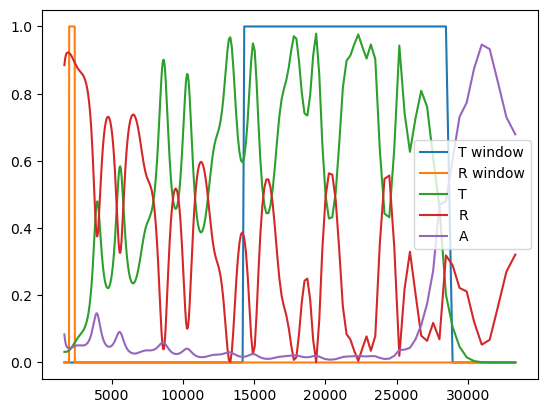

In [4]:

plt.plot(test.wavenumber_array * 1e-2, test.transmissive_envelope, label='T window')
plt.plot(test.wavenumber_array * 1e-2, test.reflective_envelope, label='R window')
plt.plot(test.wavenumber_array * 1e-2, test.transmissivity_array, label='T')
plt.plot(test.wavenumber_array * 1e-2, test.reflectivity_array, label='R')
plt.plot(test.wavenumber_array * 1e-2, test.emissivity_array, label='A')
plt.legend()

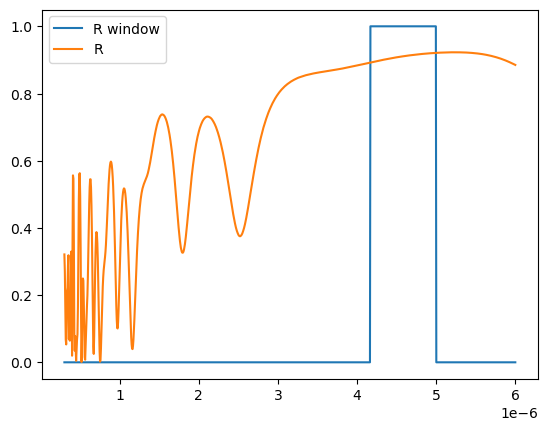

In [5]:
#plt.plot(test.wavelength_array, test.transmissive_envelope, label='T window')
plt.plot(test.wavelength_array, test.reflective_envelope, label='R window')
#plt.plot(test.wavelength_array, test.transmissivity_array, label='T')
plt.plot(test.wavelength_array, test.reflectivity_array, label='R')
#plt.plot(test.wavelength_array, test.emissivity_array, label='A')
plt.legend()


#plt.xlim(1000, 3000)

In [24]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air", "SiO2", "TiO2", "SiO2", "Ag", "Air"],
    "Thickness_List": [0, 700e-9, 550e-9, 700e-9, 5e-9, 0],
    "reflective_window_wn" : [2000, 2400],
    "transmissive_window_nm" : [350, 700]
}

# start the spectrum driver
sf = wptherml.SpectrumFactory()
# create an instance using the TMM with the structure defined as above
test = sf.spectrum_factory('Tmm', test_args)

def update_multilayer(x):
    """ function to update the thicknesses of each layer given an
        array of thicknesses stored in x"""
    test.thickness_array[1:test.number_of_layers-1] = x * 1e-9
    test.compute_spectrum()
    test.compute_selective_mirror_fom()

    ### return negative of cooling power - minimize functions want 
    ### to minimize, so trick them by passing negative of the objective you
    ### want to maximize
    return test.normalized_scaled_squared_reflectivity_error + test.normalized_scaled_squared_transmissivity_error

### given an array of thicknesses of the coating, update
### the structure and compute the gradient vector of conversion efficiency wrt layer thicknesses
#def analytic_grad(x0):
#    cur = update_multilayer(x0)
#    cool_ml.compute_cooling_gradient()
#
#    g = cool_ml.net_cooling_power_gradient
#    ### scale gradient to be in nm^-1 rather than over m^-1
#    return -g*1e-9

### function to call FOM
def SuperFunc(x0):
    en = update_multilayer(x0)
    print(x0, en)
    return en


# the bounds for L-BFGS-B updates!
# minimum layer thickness is 1 nm
bfgs_xmin = np.ones(test.number_of_layers-2)
# maximum layer thickness is 400 nm
bfgs_xmax = 800*np.ones(test.number_of_layers-2)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]
bfgs_bounds[test.number_of_layers-3] = (1.0, 5.0)

xs = np.array([700, 550, 700, 5])
### print out initial solution vector and initial efficiency
print("xs is ")
print(xs)
fom = update_multilayer(xs)
print("initial FOM is ", fom)

### run l-bfgs-b algorithm!
ret = minimize(SuperFunc, xs, method="L-BFGS-B", jac=False, bounds=bfgs_bounds)

### print optimal solution and its efficiency!
print("Optimal Structure")
print(ret.x)
print("Optimal FOM")
print(update_multilayer(ret.x))

 Your spectra have been computed! 😎 
xs is 
[700 550 700   5]
initial FOM is  380.61738867880376
[700. 550. 700.   5.] 380.61738867880376
[700.00000001 550.         700.           5.        ] 380.6173886812805
[700.         550.00000001 700.           5.        ] 380.6173886736793
[700.         550.         700.00000001   5.        ] 380.617388674731
[700.         550.         700.           4.99999999] 380.61738681882514
[699.75232774 550.5124487  700.40727709   1.        ] 119.19909190079342
[699.75232775 550.5124487  700.40727709   1.        ] 119.19909190171724
[699.75232774 550.51244871 700.40727709   1.        ] 119.19909190044851
[699.75232774 550.5124487  700.4072771    1.        ] 119.1990919002189
[699.75232774 550.5124487  700.40727709   1.00000001] 119.19909174584558
[699.7692431  550.47457726 700.37772896   1.30712842] 116.12334171131337
[699.76924311 550.47457726 700.37772896   1.30712842] 116.1233417123444
[699.7692431  550.47457727 700.37772896   1.30712842] 116.1233417

[554.39039597 619.82247104 800.           1.77358378] 93.52560414449157
[554.39039596 619.82247105 800.           1.77358378] 93.52560414417208
[554.39039596 619.82247104 799.99999999   1.77358378] 93.52560414457815
[554.39039596 619.82247104 800.           1.77358379] 93.52560410696938
[542.11564647 622.19039002 800.           1.72894021] 93.00396780524157
[542.11564648 622.19039002 800.           1.72894021] 93.00396780592837
[542.11564647 622.19039003 800.           1.72894021] 93.0039678057422
[542.11564647 622.19039002 799.99999999   1.72894021] 93.00396780603761
[542.11564647 622.19039002 800.           1.72894022] 93.00396775304648
[463.22018958 637.39184726 800.           1.57524575] 87.32545381035824
[463.22018959 637.39184726 800.           1.57524575] 87.32545381108767
[463.22018958 637.39184727 800.           1.57524575] 87.32545381103157
[463.22018958 637.39184726 799.99999999   1.57524575] 87.3254538108395
[463.22018958 637.39184726 800.           1.57524576] 87.325453700

[209.55447785 725.97513569 800.           2.15227088] 71.80499036403017
[209.4916869  726.07270239 800.           2.15294236] 71.80497748851856
[209.49168691 726.07270239 800.           2.15294236] 71.80497748851815
[209.4916869  726.0727024  800.           2.15294236] 71.80497748851792
[209.4916869  726.07270239 799.99999999   2.15294236] 71.8049774891065
[209.4916869  726.07270239 800.           2.15294237] 71.80497748850547
[209.4868565  726.08020804 800.           2.15299401] 71.80497745201095
[209.48685651 726.08020804 800.           2.15299401] 71.80497745201052
[209.4868565  726.08020805 800.           2.15299401] 71.8049774520107
[209.4868565  726.08020804 799.99999999   2.15299401] 71.80497745259885
[209.4868565  726.08020804 800.           2.15299402] 71.80497745200165
Optimal Structure
[209.4868565  726.08020804 800.           2.15299401]
Optimal FOM
71.80497745201095


In [25]:
print(test.thickness_array)

[0.00000000e+00 2.09486856e-07 7.26080208e-07 8.00000000e-07
 2.15299401e-09 0.00000000e+00]


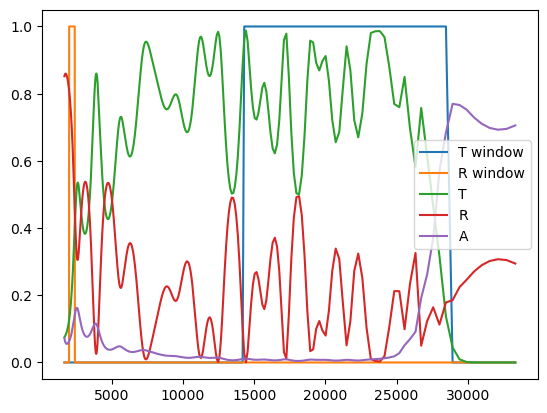

In [26]:

plt.plot(test.wavenumber_array * 1e-2, test.transmissive_envelope, label='T window')
plt.plot(test.wavenumber_array * 1e-2, test.reflective_envelope, label='R window')
plt.plot(test.wavenumber_array * 1e-2, test.transmissivity_array, label='T')
plt.plot(test.wavenumber_array * 1e-2, test.reflectivity_array, label='R')
plt.plot(test.wavenumber_array * 1e-2, test.emissivity_array, label='A')
plt.legend()

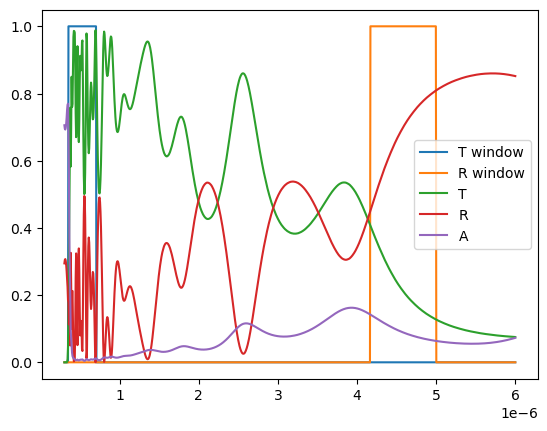

In [27]:
plt.plot(test.wavelength_array, test.transmissive_envelope, label='T window')
plt.plot(test.wavelength_array, test.reflective_envelope, label='R window')
plt.plot(test.wavelength_array, test.transmissivity_array, label='T')
plt.plot(test.wavelength_array, test.reflectivity_array, label='R')
plt.plot(test.wavelength_array, test.emissivity_array, label='A')
plt.legend()

In [28]:
bfgs_xmin = np.ones(test.number_of_layers-2)
# maximum layer thickness is 400 nm
bfgs_xmax = 800*np.ones(test.number_of_layers-2)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

bfgs_bounds[test.number_of_layers-3] = (1.0, 5.0)
print(bfgs_bounds)

[(1.0, 800.0), (1.0, 800.0), (1.0, 800.0), (1.0, 5.0)]


In [29]:
### prints efficiency and time
def print_fun(x, f, accepted):
    c_time = time.time()
    print(f,",",c_time)

### called by the basin hopping algorithm to initiate new
### local optimizations
def my_take_step(x):
    xnew = np.copy(x)
    dim = len(xnew)
    for i in range(0,dim):
        rn = 50.*np.abs(np.random.randn())
        xnew[i] = rn
    return xnew

test.number_of_layers-2
### bounds on basin hopping solutions
class MyBounds(object):
      ### note xmax and xmin need to have as many elements as there are thicknesses that are varied
    def __init__(self, xmax=800.0*np.ones(test.number_of_layers-2), xmin=1.0*np.ones(test.number_of_layers-2)):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

# the bounds for L-BFGS-B updates!
bfgs_xmin = 1.0*np.ones(test.number_of_layers-2)
bfgs_xmax = 800.0*np.ones(test.number_of_layers-2)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### arguments for basin hopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "jac": False, "bounds": bfgs_bounds}
mybounds = MyBounds()

### initial guess for AR layer thicknesses!
xs = np.array([209.4868565,  726.08020804, 800.,           2.1529940])

### call basin hopping!
ret = basinhopping(SuperFunc, xs, minimizer_kwargs=minimizer_kwargs, niter=100, take_step=my_take_step, callback=print_fun, accept_test=mybounds)

### print optimimal result!
print(ret.x)
print(update_multilayer(ret.x))

[209.4868565  726.08020804 800.           2.152994  ] 71.80497745202233
[209.48685651 726.08020804 800.           2.152994  ] 71.80497745202248
[209.4868565  726.08020805 800.           2.152994  ] 71.80497745202229
[209.4868565  726.08020804 799.99999999   2.152994  ] 71.80497745261074
[209.4868565  726.08020804 800.           2.15299401] 71.80497745201274
[209.48684087 726.0802123  800.           2.15395323] 71.80498727425552
[209.48684088 726.0802123  800.           2.15395323] 71.8049872742552
[209.48684087 726.08021231 800.           2.15395323] 71.80498727425429
[209.48684087 726.0802123  799.99999999   2.15395323] 71.80498727484468
[209.48684087 726.0802123  800.           2.15395324] 71.80498727446974
[209.48685583 726.08020822 800.           2.15303503] 71.80497743262309
[209.48685584 726.08020822 800.           2.15303503] 71.8049774326229
[209.48685583 726.08020823 800.           2.15303503] 71.80497743262312
[209.48685583 726.08020822 799.99999999   2.15303503] 71.804977433

[55.63653569 78.19779245 76.39447671  2.85067972] 141.69566867646316
[55.38590006 78.35648645 76.08080337  2.84436241] 141.68914187807786
[55.38590007 78.35648645 76.08080337  2.84436241] 141.68914187851706
[55.38590006 78.35648646 76.08080337  2.84436241] 141.68914187804182
[55.38590006 78.35648645 76.08080338  2.84436241] 141.68914187792512
[55.38590006 78.35648645 76.08080337  2.84436242] 141.68914187578196
[54.55492635 78.745482   75.58904291  2.83291807] 141.66829881479003
[54.55492636 78.745482   75.58904291  2.83291807] 141.66829881514343
[54.55492635 78.74548201 75.58904291  2.83291807] 141.66829881483451
[54.55492635 78.745482   75.58904292  2.83291807] 141.6682988145932
[54.55492635 78.745482   75.58904291  2.83291808] 141.66829881115856
[53.12832729 78.54889496 75.60551633  2.8088506 ] 141.6401815809449
[53.1283273  78.54889496 75.60551633  2.8088506 ] 141.64018158113583
[53.12832729 78.54889497 75.60551633  2.8088506 ] 141.64018158086725
[53.12832729 78.54889496 75.60551634

[ 23.64510824 100.76212629 107.56154022   1.00000001] 160.14372464046644
[ 29.62498516 151.32476523 110.21631629  75.55147695] 882.8693301405747
[ 29.62498517 151.32476523 110.21631629  75.55147695] 882.8693301403353
[ 29.62498516 151.32476524 110.21631629  75.55147695] 882.8693301407125
[ 29.62498516 151.32476523 110.2163163   75.55147695] 882.869330140926
[ 29.62498516 151.32476523 110.21631629  75.55147696] 882.869330142347
[ 26.6350467  126.04344576 108.88892825  38.27573848] 861.8244256069679
[ 26.63504671 126.04344576 108.88892825  38.27573848] 861.8244256061674
[ 26.6350467  126.04344577 108.88892825  38.27573848] 861.8244256053522
[ 26.6350467  126.04344576 108.88892826  38.27573848] 861.8244256059427
[ 26.6350467  126.04344576 108.88892825  38.27573849] 861.8244256196142
[ 24.13032951 104.86489768 107.77695499   7.04928211] 320.70515553009267
[ 24.13032952 104.86489768 107.77695499   7.04928211] 320.70515552660754
[ 24.13032951 104.86489769 107.77695499   7.04928211] 320.70515

[87.53834742 71.38148739 13.80700874 28.16507975] 838.9580011312356
[87.53834742 71.38148739 13.80700873 28.16507976] 838.9580011667633
[87.46163149 71.68523608 13.3301948  24.13549559] 819.7445506501675
[87.4616315  71.68523608 13.3301948  24.13549559] 819.744550651145
[87.46163149 71.68523609 13.3301948  24.13549559] 819.7445506466297
[87.46163149 71.68523608 13.33019481 24.13549559] 819.7445506558723
[87.46163149 71.68523608 13.3301948  24.1354956 ] 819.7445507041031
[87.15476779 72.90023081 11.4229391   8.01715897] 629.3160407602991
[87.1547678  72.90023081 11.4229391   8.01715897] 629.3160407535006
[87.15476779 72.90023082 11.4229391   8.01715897] 629.3160407233127
[87.15476779 72.90023081 11.42293911  8.01715897] 629.3160407450151
[87.15476779 72.90023081 11.4229391   8.01715898] 629.3160428146812
[87.02117389 73.42918187 10.59261046  1.        ] 172.3693398574491
[87.0211739  73.42918187 10.59261046  1.        ] 172.36933984750152
[87.02117389 73.42918188 10.59261046  1.        

[97.61251324 93.40360401  1.00000001  2.35365431] 130.93348188833127
[97.61251324 93.40360401  1.          2.35365432] 130.9334818881702
[97.61434634 93.40572525  1.          2.35364606] 130.93348194741824
[97.61434635 93.40572525  1.          2.35364606] 130.9334819474188
[97.61434634 93.40572526  1.          2.35364606] 130.93348194741898
[97.61434634 93.40572525  1.00000001  2.35364606] 130.93348194758067
[97.61434634 93.40572525  1.          2.35364607] 130.93348194741358
[97.61314566 93.40433584  1.          2.35365146] 130.93348187105633
[97.61314567 93.40433584  1.          2.35365146] 130.93348187105605
[97.61314566 93.40433585  1.          2.35365146] 130.93348187105627
[97.61314566 93.40433584  1.00000001  2.35365146] 130.9334818712184
[97.61314566 93.40433584  1.          2.35365147] 130.93348187105522
130.93348187105633 , 1687402011.040863
[  8.65982987  96.26946629 110.35313886   8.93352719] 616.828286697502
[  8.65982988  96.26946629 110.35313886   8.93352719] 616.8282866

[ 18.29112835  87.33287909 115.99338528   2.55919233] 126.61316469613344
[ 18.29112835  87.33287909 115.99338527   2.55919234] 126.61316469537834
[ 18.13852138  87.51929455 115.85237917   2.55847013] 126.61172674833628
[ 18.13852139  87.51929455 115.85237917   2.55847013] 126.61172674815944
[ 18.13852138  87.51929456 115.85237917   2.55847013] 126.61172674839187
[ 18.13852138  87.51929455 115.85237918   2.55847013] 126.61172674867345
[ 18.13852138  87.51929455 115.85237917   2.55847014] 126.61172674769972
[ 17.43143126  87.52726512 115.03187697   2.4752902 ] 126.65702103537066
[ 17.43143127  87.52726512 115.03187697   2.4752902 ] 126.65702103521762
[ 17.43143126  87.52726513 115.03187697   2.4752902 ] 126.65702103544191
[ 17.43143126  87.52726512 115.03187698   2.4752902 ] 126.65702103568893
[ 17.43143126  87.52726512 115.03187697   2.47529021] 126.6570210214236
[ 18.07533995  87.52000675 115.77906389   2.55103766] 126.61129006400685
[ 18.07533996  87.52000675 115.77906389   2.55103766

[  1.         331.52770525   1.00000001  38.30305208] 863.1360885025417
[  1.         331.52770525   1.          38.30305209] 863.1360885110349
[  1.         118.07912198  32.73699448   6.47783239] 320.64123321100317
[  1.00000001 118.07912198  32.73699448   6.47783239] 320.6412332062796
[  1.         118.07912199  32.73699448   6.47783239] 320.64123319184506
[  1.         118.07912198  32.73699449   6.47783239] 320.6412332034369
[  1.         118.07912198  32.73699448   6.4778324 ] 320.64123425608904
[ 1.         90.86383028 36.78355009  2.42002782] 149.4702228324516
[ 1.00000001 90.86383028 36.78355009  2.42002782] 149.4702228326475
[ 1.         90.86383029 36.78355009  2.42002782] 149.4702228364448
[ 1.         90.86383028 36.7835501   2.42002782] 149.4702228348081
[ 1.         90.86383028 36.78355009  2.42002783] 149.47022288012624
[ 1.         86.85272729 37.28920558  2.19750276] 148.2351387569643
[ 1.00000001 86.85272729 37.28920558  2.19750276] 148.23513875648973
[ 1.         86

[ 4.5304393  28.98677666  3.42370628 86.51009117] 903.1958070157846
[ 4.53043931 28.98677666  3.42370628 86.51009117] 903.1958070155572
[ 4.5304393  28.98677667  3.42370628 86.51009117] 903.1958070156628
[ 4.5304393  28.98677666  3.42370629 86.51009117] 903.1958070174085
[ 4.5304393  28.98677666  3.42370628 86.51009118] 903.1958070166769
[ 4.55317667 28.99895252  3.261316   86.42085831] 903.1606546526253
[ 4.55317668 28.99895252  3.261316   86.42085831] 903.1606546523993
[ 4.55317667 28.99895253  3.261316   86.42085831] 903.1606546525115
[ 4.55317667 28.99895252  3.26131601 86.42085831] 903.1606546542641
[ 4.55317667 28.99895252  3.261316   86.42085832] 903.160654653529
[ 4.64412614 29.04765595  2.61175488 86.06392689] 903.017101916573
[ 4.64412615 29.04765595  2.61175488 86.06392689] 903.0171019163495
[ 4.64412614 29.04765596  2.61175488 86.06392689] 903.0171019165027
[ 4.64412614 29.04765595  2.61175489 86.06392689] 903.0171019182649
[ 4.64412614 29.04765595  2.61175488 86.0639269 ] 

[16.76185481 15.01086249  1.          2.02520622] 150.50023646953312
[16.76185481 15.01086248  1.00000001  2.02520622] 150.50023647144727
[16.76185481 15.01086248  1.          2.02520623] 150.50023647699223
[16.54505267 15.02821817  1.          2.01816685] 150.45473646204275
[16.54505268 15.02821817  1.          2.01816685] 150.4547364638735
[16.54505267 15.02821818  1.          2.01816685] 150.45473646114178
[16.54505267 15.02821817  1.00000001  2.01816685] 150.45473646305686
[16.54505267 15.02821817  1.          2.01816686] 150.45473646703002
[15.67784407 15.09764095  1.          1.9900094 ] 150.28760166773614
[15.67784408 15.09764095  1.          1.9900094 ] 150.28760166949712
[15.67784407 15.09764096  1.          1.9900094 ] 150.28760166681292
[15.67784407 15.09764095  1.00000001  1.9900094 ] 150.2876016687331
[15.67784407 15.09764095  1.          1.99000941] 150.28760166640672
[ 4.9906043  16.01085081  1.          1.85874055] 148.98324319923032
[ 4.99060431 16.01085081  1.        

[ 90.78555646   5.60718633 122.89101678   9.29160607] 722.9521349017381
[ 90.78555647   5.60718633 122.89101678   9.29160607] 722.9521349016472
[ 90.78555646   5.60718634 122.89101678   9.29160607] 722.9521349022292
[ 90.78555646   5.60718633 122.89101679   9.29160607] 722.9521349017389
[ 90.78555646   5.60718633 122.89101678   9.29160608] 722.9521349043781
[ 90.83473051   5.29785205 122.90002141   9.29229305] 722.9410034052438
[ 90.83473052   5.29785205 122.90002141   9.29229305] 722.9410034051576
[ 90.83473051   5.29785206 122.90002141   9.29229305] 722.9410034054592
[ 90.83473051   5.29785205 122.90002142   9.29229305] 722.941003405249
[ 90.83473051   5.29785205 122.90002141   9.29229306] 722.9410034081893
[ 91.01037796   5.02084025 123.00019843   9.26340854] 722.9313138745949
[ 91.01037797   5.02084025 123.00019843   9.26340854] 722.9313138745363
[ 91.01037796   5.02084026 123.00019843   9.26340854] 722.9313138745842
[ 91.01037796   5.02084025 123.00019844   9.26340854] 722.9313138

[23.22256094  1.8905986  32.42283207  9.74708221] 749.7625411839498
[23.22256093  1.89059861 32.42283207  9.74708221] 749.762541210204
[23.22256093  1.8905986  32.42283208  9.74708221] 749.7625411854557
[23.22256093  1.8905986  32.42283207  9.74708222] 749.7625411615833
[21.76561728  1.         30.56116763 12.71476346] 759.1755354779984
[21.76561729  1.         30.56116763 12.71476346] 759.1755354784864
[21.76561728  1.00000001 30.56116763 12.71476346] 759.1755354774566
[21.76561728  1.         30.56116764 12.71476346] 759.1755354789927
[21.76561728  1.         30.56116763 12.71476347] 759.1755355439702
[22.94331023  1.7198986  32.06600901 10.31589423] 748.9600205954476
[22.94331024  1.7198986  32.06600901 10.31589423] 748.9600206002539
[22.94331023  1.71989861 32.06600901 10.31589423] 748.960020618066
[22.94331023  1.7198986  32.06600902 10.31589423] 748.9600206014974
[22.94331023  1.7198986  32.06600901 10.31589424] 748.9600206116406
[22.41173764  1.         31.21579196  9.76372146] 

[37.26206367 20.63740671  1.          9.32959378] 720.8049656579446
[37.26206368 20.63740671  1.          9.32959378] 720.8049656579423
[37.26206367 20.63740672  1.          9.32959378] 720.8049656579444
[37.26206367 20.63740671  1.00000001  9.32959378] 720.8049656624635
[37.26206367 20.63740671  1.          9.32959379] 720.8049656579489
[37.26333518 20.63740689  1.          9.32953973] 720.804965565853
[37.26333519 20.63740689  1.          9.32953973] 720.804965565851
[37.26333518 20.6374069   1.          9.32953973] 720.8049655658497
[37.26333518 20.63740689  1.00000001  9.32953973] 720.8049655703696
[37.26333518 20.63740689  1.          9.32953974] 720.8049655658543
[37.26375474 20.63740695  1.          9.32952189] 720.8049655450953
[37.26375475 20.63740695  1.          9.32952189] 720.8049655450984
[37.26375474 20.63740696  1.          9.32952189] 720.8049655450952
[37.26375474 20.63740695  1.00000001  9.32952189] 720.8049655496148
[37.26375474 20.63740695  1.          9.3295219 ] 

[96.73780368 93.98748937  1.3361643   2.35656185] 130.94870934747362
[96.73780367 93.98748938  1.3361643   2.35656185] 130.94870934776552
[96.73780367 93.98748937  1.33616431  2.35656185] 130.94870934772473
[96.73780367 93.98748937  1.3361643   2.35656186] 130.94870934724779
[96.80157717 94.02788245  1.          2.35548572] 130.94282453031548
[96.80157718 94.02788245  1.          2.35548572] 130.94282453026779
[96.80157717 94.02788246  1.          2.35548572] 130.94282453055544
[96.80157717 94.02788245  1.00000001  2.35548572] 130.94282453050818
[96.80157717 94.02788245  1.          2.35548573] 130.94282452986067
[97.66814239 93.38542737  1.          2.34817037] 130.93375545534178
[97.6681424  93.38542737  1.          2.34817037] 130.93375545534786
[97.66814239 93.38542738  1.          2.34817037] 130.93375545534553
[97.66814239 93.38542737  1.00000001  2.34817037] 130.93375545550464
[97.66814239 93.38542737  1.          2.34817038] 130.93375545439253
[97.71882668 93.42469803  1.      

[ 1.         16.50798617  1.00000001  1.98158916] 148.48036254498408
[ 1.         16.50798617  1.          1.98158917] 148.48036254749584
[ 1.         17.23850266  1.          1.96707917] 148.44716233277592
[ 1.00000001 17.23850266  1.          1.96707917] 148.44716233354006
[ 1.         17.23850267  1.          1.96707917] 148.44716233295202
[ 1.         17.23850266  1.00000001  1.96707917] 148.447162333748
[ 1.         17.23850266  1.          1.96707918] 148.44716233364835
[ 1.         17.13538193  1.          1.96328993] 148.44607756798064
[ 1.00000001 17.13538193  1.          1.96328993] 148.44607756872233
[ 1.         17.13538194  1.          1.96328993] 148.44607756798868
[ 1.         17.13538193  1.00000001  1.96328993] 148.4460775689221
[ 1.         17.13538193  1.          1.96328994] 148.4460775677803
[ 1.         17.12890858  1.          1.96423851] 148.4460663616326
[ 1.00000001 17.12890858  1.          1.96423851] 148.44606636237327
[ 1.         17.12890859  1.          1

[125.0231308   19.54945128   4.66894251   2.07825305] 140.15449011381617
[125.02313081  19.54945128   4.66894251   2.07825305] 140.1544901142056
[125.0231308   19.54945129   4.66894251   2.07825305] 140.15449011348008
[125.0231308   19.54945128   4.66894252   2.07825305] 140.1544901141837
[125.0231308   19.54945128   4.66894251   2.07825306] 140.1544901136986
[124.79405214  21.08996674   1.           2.10932027] 140.0287966911643
[124.79405215  21.08996674   1.           2.10932027] 140.02879669166134
[124.79405214  21.08996675   1.           2.10932027] 140.02879669151497
[124.79405214  21.08996674   1.00000001   2.10932027] 140.02879669150093
[124.79405214  21.08996674   1.           2.10932028] 140.02879669780674
[123.57233188  21.44020951   1.           2.09772365] 139.97984300007514
[123.57233189  21.44020951   1.           2.09772365] 139.97984300049745
[123.57233188  21.44020952   1.           2.09772365] 139.97984300051286
[123.57233188  21.44020951   1.00000001   2.09772365] 1

[ 61.94071834   1.         148.41061973   9.25080209] 724.1441423004426
[ 62.05244056   1.         148.52313988   9.21371938] 724.1376646751527
[ 62.05244057   1.         148.52313988   9.21371938] 724.1376646750371
[ 62.05244056   1.00000001 148.52313988   9.21371938] 724.137664676189
[ 62.05244056   1.         148.52313989   9.21371938] 724.1376646752929
[ 62.05244056   1.         148.52313988   9.21371939] 724.1376646755232
[ 62.03273529   1.         148.4962532    9.20917499] 724.137431148857
[ 62.0327353    1.         148.4962532    9.20917499] 724.1374311487401
[ 62.03273529   1.00000001 148.4962532    9.20917499] 724.1374311498954
[ 62.03273529   1.         148.49625321   9.20917499] 724.137431148994
[ 62.03273529   1.         148.4962532    9.209175  ] 724.1374311489171
[ 62.03926504   1.         148.46299798   9.20416178] 724.1369579038452
[ 62.03926505   1.         148.46299798   9.20416178] 724.1369579037269
[ 62.03926504   1.00000001 148.46299798   9.20416178] 724.136957904

[ 92.92549087   4.99408988 120.84580366   9.24433339] 722.9212314257289
[ 92.92549088   4.99408988 120.84580366   9.24433339] 722.9212314257286
[ 92.92549087   4.99408989 120.84580366   9.24433339] 722.9212314257297
[ 92.92549087   4.99408988 120.84580367   9.24433339] 722.9212314257286
[ 92.92549087   4.99408988 120.84580366   9.2443334 ] 722.9212314257296
722.9212314257289 , 1687402068.464097
[13.08983681  4.56506763 63.77176175  3.62029315] 235.38017615687392
[13.08983682  4.56506763 63.77176175  3.62029315] 235.38017615711243
[13.08983681  4.56506764 63.77176175  3.62029315] 235.38017613004956
[13.08983681  4.56506763 63.77176176  3.62029315] 235.38017616250042
[13.08983681  4.56506763 63.77176175  3.62029316] 235.38017649459832
[13.06598531  7.2475029  63.20911143  1.        ] 288.350548393273
[13.06598532  7.2475029  63.20911143  1.        ] 288.3505483896145
[13.06598531  7.24750291 63.20911143  1.        ] 288.3505482983292
[13.06598531  7.2475029  63.20911144  1.        ] 288.

[10.91987313 90.69526272  1.          2.10659212] 144.76348581100436
[10.91987312 90.69526273  1.          2.10659212] 144.7634858110451
[10.91987312 90.69526272  1.00000001  2.10659212] 144.76348581106373
[10.91987312 90.69526272  1.          2.10659213] 144.76348580971862
[10.83705597 90.66658426  1.          2.11158602] 144.762954468639
[10.83705598 90.66658426  1.          2.11158602] 144.76295446864137
[10.83705597 90.66658427  1.          2.11158602] 144.76295446865012
[10.83705597 90.66658426  1.00000001  2.11158602] 144.7629544687061
[10.83705597 90.66658426  1.          2.11158603] 144.7629544684155
[10.82392497 90.65721149  1.          2.11263138] 144.76293657038903
[10.82392498 90.65721149  1.          2.11263138] 144.7629365703884
[10.82392497 90.6572115   1.          2.11263138] 144.7629365703886
[10.82392497 90.65721149  1.00000001  2.11263138] 144.7629365704547
[10.82392497 90.65721149  1.          2.11263139] 144.76293657038912
[10.83721265 90.65540248  1.          2.11

[57.83617157 83.20824179 60.26089712  2.82909836] 143.6094591129367
[57.83617156 83.2082418  60.26089712  2.82909836] 143.60945911343953
[57.83617156 83.20824179 60.26089713  2.82909836] 143.60945911056106
[57.83617156 83.20824179 60.26089712  2.82909837] 143.6094591211392
[57.82297499 83.65729665 61.70036847  2.89604015] 143.47183996584067
[57.822975   83.65729665 61.70036847  2.89604015] 143.4718399662543
[57.82297499 83.65729666 61.70036847  2.89604015] 143.4718399668217
[57.82297499 83.65729665 61.70036848  2.89604015] 143.47183996397342
[57.82297499 83.65729665 61.70036847  2.89604016] 143.47183998512622
[57.64566082 83.94690552 64.20758879  2.96874568] 143.22750483843154
[57.64566083 83.94690552 64.20758879  2.96874568] 143.2275048388176
[57.64566082 83.94690553 64.20758879  2.96874568] 143.22750483942005
[57.64566082 83.94690552 64.2075888   2.96874568] 143.22750483676307
[57.64566082 83.94690552 64.20758879  2.96874569] 143.22750486806663
[57.02268015 83.66256184 69.19335175  3

[ 48.7240045   70.77941958 126.58693951   3.5926265 ] 140.2285635445352
[ 48.7240045   70.77941958 126.5869395    3.59262651] 140.22856372038055
[ 33.57256066  72.18670394 113.00580523   3.17526309] 136.74233453847168
[ 33.57256067  72.18670394 113.00580523   3.17526309] 136.74233453711264
[ 33.57256066  72.18670395 113.00580523   3.17526309] 136.74233452535753
[ 33.57256066  72.18670394 113.00580524   3.17526309] 136.7423345347529
[ 33.57256066  72.18670394 113.00580523   3.1752631 ] 136.74233466665615
[  1.         686.82025431   1.           1.        ] 147.6577861853028
[  1.00000001 686.82025431   1.           1.        ] 147.6577861856218
[  1.         686.82025432   1.           1.        ] 147.65778618696552
[  1.         686.82025431   1.00000001   1.        ] 147.65778618638748
[  1.         686.82025431   1.           1.00000001] 147.65778598077222
[ 22.08919176 288.87411363  73.51845901   2.40837992] 162.50514671529572
[ 22.08919177 288.87411363  73.51845901   2.40837992] 1

[80.46653743 37.89882928  1.8526167   2.07791688] 154.03130616345769
[80.46653743 37.89882927  1.85261671  2.07791688] 154.0313061592042
[80.46653743 37.89882927  1.8526167   2.07791689] 154.03130614553018
[82.52544581 36.73237766  1.74376181  2.71624496] 155.49381516552896
[82.52544582 36.73237766  1.74376181  2.71624496] 155.4938151582777
[82.52544581 36.73237767  1.74376181  2.71624496] 155.49381517007222
[82.52544581 36.73237766  1.74376182  2.71624496] 155.49381516780818
[82.52544581 36.73237766  1.74376181  2.71624497] 155.49381529648363
[81.18418049 37.49225659  1.81467477  2.3004094 ] 153.45147303261436
[81.1841805  37.49225659  1.81467477  2.3004094 ] 153.45147302443831
[81.18418049 37.4922566   1.81467477  2.3004094 ] 153.4514730385588
[81.18418049 37.49225659  1.81467478  2.3004094 ] 153.4514730350434
[81.18418049 37.49225659  1.81467477  2.30040941] 153.45147307033199
[114.77364072  17.22647712   1.           1.52150452] 144.8654946805364
[114.77364073  17.22647712   1.    

[15.54028474 14.38421198 21.1138024   2.02745317] 154.66207198812845
[15.54028475 14.38421198 21.1138024   2.02745317] 154.66207199075976
[15.54028474 14.38421199 21.1138024   2.02745317] 154.66207199010145
[15.54028474 14.38421198 21.11380241  2.02745317] 154.66207199162815
[15.54028474 14.38421198 21.1138024   2.02745318] 154.66207199311188
[15.53206075 14.36205347 21.10482452  2.01126687] 154.64761392214848
[15.53206076 14.36205347 21.10482452  2.01126687] 154.64761392478457
[15.53206075 14.36205348 21.10482452  2.01126687] 154.64761392405808
[15.53206075 14.36205347 21.10482453  2.01126687] 154.6476139256502
[15.53206075 14.36205347 21.10482452  2.01126688] 154.64761392315145
[15.49187086 14.25846056 21.06053307  1.98479304] 154.60896642633622
[15.49187087 14.25846056 21.06053307  1.98479304] 154.60896642897103
[15.49187086 14.25846057 21.06053307  1.98479304] 154.6089664280333
[15.49187086 14.25846056 21.06053308  1.98479304] 154.6089664298285
[15.49187086 14.25846056 21.06053307 

[31.92988957 77.30619876 54.79161862  2.01959624] 150.7484290885078
[34.88563966 85.27681511 59.09295094  2.3382595 ] 147.08757613540064
[34.88563967 85.27681511 59.09295094  2.3382595 ] 147.08757613437817
[34.88563966 85.27681512 59.09295094  2.3382595 ] 147.0875761379666
[34.88563966 85.27681511 59.09295095  2.3382595 ] 147.08757613349724
[34.88563966 85.27681511 59.09295094  2.33825951] 147.08757605789123
[35.57473204 86.82620838 60.11863546  2.64010196] 145.77747777412134
[35.57473205 86.82620838 60.11863546  2.64010196] 145.77747777280285
[35.57473204 86.82620839 60.11863546  2.64010196] 145.77747777617324
[35.57473204 86.82620838 60.11863547  2.64010196] 145.77747777185485
[35.57473204 86.82620838 60.11863546  2.64010197] 145.77747775983173
[35.65216781 86.92493272 60.23930273  2.71104089] 145.71310040828578
[35.65216782 86.92493272 60.23930273  2.71104089] 145.71310040687348
[35.65216781 86.92493273 60.23930273  2.71104089] 145.71310041003264
[35.65216781 86.92493272 60.23930274

[ 91.35942662  92.34724387 123.91086744   2.96609378] 121.53190102366692
[ 91.35942663  92.34724387 123.91086744   2.96609378] 121.53190102341736
[ 91.35942662  92.34724388 123.91086744   2.96609378] 121.53190102402064
[ 91.35942662  92.34724387 123.91086745   2.96609378] 121.53190102415643
[ 91.35942662  92.34724387 123.91086744   2.96609379] 121.53190104748353
[ 27.24684788 144.70895873   1.           3.54751949] 140.52751124637285
[ 27.24684789 144.70895873   1.           3.54751949] 140.52751124638925
[ 27.24684788 144.70895874   1.           3.54751949] 140.52751124666315
[ 27.24684788 144.70895873   1.00000001   3.54751949] 140.52751124694925
[ 27.24684788 144.70895873   1.           3.5475195 ] 140.52751139747085
[ 90.67997396  92.90216316 122.60828195   2.97225561] 121.52514545141685
[ 90.67997397  92.90216316 122.60828195   2.97225561] 121.525145451132
[ 90.67997396  92.90216317 122.60828195   2.97225561] 121.5251454518078
[ 90.67997396  92.90216316 122.60828196   2.97225561] 

[28.15924126 20.47123957  1.          9.3321171 ] 721.4451293695939
[28.15924126 20.47123956  1.00000001  9.3321171 ] 721.4451293735825
[28.15924126 20.47123956  1.          9.33211711] 721.4451293695332
[28.40409676 20.65676815  1.          9.41354862] 721.4064054498134
[28.40409677 20.65676815  1.          9.41354862] 721.4064054486269
[28.40409676 20.65676816  1.          9.41354862] 721.4064054489038
[28.40409676 20.65676815  1.00000001  9.41354862] 721.4064054529168
[28.40409676 20.65676815  1.          9.41354863] 721.4064054530425
[28.65961173 20.85087302  1.          9.45088304] 721.3761228822751
[28.65961174 20.85087302  1.          9.45088304] 721.3761228811375
[28.65961173 20.85087303  1.          9.45088304] 721.3761228815282
[28.65961173 20.85087302  1.00000001  9.45088304] 721.3761228855243
[28.65961173 20.85087302  1.          9.45088305] 721.3761228873393
[29.52184342 21.49504053  1.          9.50518749] 721.289770615449
[29.52184343 21.49504053  1.          9.50518749]

[ 42.42188083 126.93621479 116.01612419 142.50030384] 885.5306642117837
[ 42.42188082 126.9362148  116.01612419 142.50030384] 885.5306642115968
[ 42.42188082 126.93621479 116.0161242  142.50030384] 885.5306642118845
[ 42.42188082 126.93621479 116.01612419 142.50030385] 885.530664211806
[ 43.17648866 133.90753181 103.59746461 140.21051623] 885.4753407196162
[ 43.17648867 133.90753181 103.59746461 140.21051623] 885.4753407196117
[ 43.17648866 133.90753182 103.59746461 140.21051623] 885.4753407194174
[ 43.17648866 133.90753181 103.59746462 140.21051623] 885.4753407193451
[ 43.17648866 133.90753181 103.59746461 140.21051624] 885.4753407196519
[ 42.83058957 134.4979632  108.5966045  139.78678262] 885.388276237467
[ 42.83058958 134.4979632  108.5966045  139.78678262] 885.3882762374509
[ 42.83058957 134.49796321 108.5966045  139.78678262] 885.3882762373671
[ 42.83058957 134.4979632  108.59660451 139.78678262] 885.3882762374299
[ 42.83058957 134.4979632  108.5966045  139.78678263] 885.38827623

[ 9.23235146 34.6687393  38.29249718  1.        ] 204.89519872888386
[ 9.23235146 34.66873929 38.29249719  1.        ] 204.89519873132937
[ 9.23235146 34.66873929 38.29249718  1.00000001] 204.89519841060627
[ 9.20743466 34.65846867 38.83546125  9.35323598] 757.0671372348198
[ 9.20743467 34.65846867 38.83546125  9.35323598] 757.0671372346762
[ 9.20743466 34.65846868 38.83546125  9.35323598] 757.0671372357352
[ 9.20743466 34.65846867 38.83546126  9.35323598] 757.0671372392533
[ 9.20743466 34.65846867 38.83546125  9.35323599] 757.0671372391155
[ 9.22808476 34.52680749 38.19784452  8.73593001] 757.8243656686066
[ 9.22808477 34.52680749 38.19784452  8.73593001] 757.8243656686759
[ 9.22808476 34.5268075  38.19784452  8.73593001] 757.8243656703991
[ 9.22808476 34.52680749 38.19784453  8.73593001] 757.8243656733636
[ 9.22808476 34.52680749 38.19784452  8.73593002] 757.8243656261579
[ 9.21208774 34.62880146 38.69178708  9.21413844] 757.0015867054498
[ 9.21208775 34.62880146 38.69178708  9.21413

[37.25837643 20.63844798  1.00000001  9.32944276] 720.8049659647139
[37.25837643 20.63844798  1.          9.32944277] 720.8049659601899
[37.26592694 20.63851622  1.          9.32949522] 720.8049654469177
[37.26592695 20.63851622  1.          9.32949522] 720.804965446919
[37.26592694 20.63851623  1.          9.32949522] 720.8049654469183
[37.26592694 20.63851622  1.00000001  9.32949522] 720.8049654514376
[37.26592694 20.63851622  1.          9.32949523] 720.8049654469164
720.8049654469177 , 1687402121.951515
[ 6.38372645 10.74501467 33.7998997   8.3796339 ] 735.7767573540258
[ 6.38372646 10.74501467 33.7998997   8.3796339 ] 735.7767573543766
[ 6.38372645 10.74501468 33.7998997   8.3796339 ] 735.7767573534537
[ 6.38372645 10.74501467 33.79989971  8.3796339 ] 735.7767573580791
[ 6.38372645 10.74501467 33.7998997   8.37963391] 735.7767572966291
[ 6.34864269 10.80222188 33.39457205 14.1193067 ] 769.8217838808623
[ 6.3486427  10.80222188 33.39457205 14.1193067 ] 769.8217838800205
[ 6.3486426

[167.00640162 299.85041045   1.           4.828055  ] 132.89544816213515
[167.00640163 299.85041045   1.           4.828055  ] 132.89544816361746
[167.00640162 299.85041046   1.           4.828055  ] 132.89544816021717
[167.00640162 299.85041045   1.00000001   4.828055  ] 132.89544816588568
[167.00640162 299.85041045   1.           4.82805501] 132.89544818207565
[154.71785607 300.68582438   1.           5.1233529 ] 131.7315600758866
[154.71785608 300.68582438   1.           5.1233529 ] 131.73156007746582
[154.71785607 300.68582439   1.           5.1233529 ] 131.73156007264407
[154.71785607 300.68582438   1.00000001   5.1233529 ] 131.73156007914864
[154.71785607 300.68582438   1.           5.12335291] 131.73156012160578
[112.64945061 305.33473317   1.           5.85454763] 130.41987133597968
[112.64945062 305.33473317   1.           5.85454763] 130.41987133659393
[112.64945061 305.33473318   1.           5.85454763] 130.4198713321823
[112.64945061 305.33473317   1.00000001   5.85454763]

[46.98895689 50.26374816 55.88678801 13.23238236] 764.6807568560599
[46.98895688 50.26374817 55.88678801 13.23238236] 764.6807568527466
[46.98895688 50.26374816 55.88678802 13.23238236] 764.6807568586855
[46.98895688 50.26374816 55.88678801 13.23238237] 764.680756945686
[47.34258554 51.37328559 56.08757246  1.        ] 184.0743361397877
[47.34258555 51.37328559 56.08757246  1.        ] 184.07433613930658
[47.34258554 51.3732856  56.08757246  1.        ] 184.07433613241963
[47.34258554 51.37328559 56.08757247  1.        ] 184.07433613847513
[47.34258554 51.37328559 56.08757246  1.00000001] 184.07433574141476
[47.05266207 50.46362816 55.92295876 11.02875354] 746.735622117141
[47.05266208 50.46362816 55.92295876 11.02875354] 746.7356221138403
[47.05266207 50.46362817 55.92295876 11.02875354] 746.7356221111139
[47.05266207 50.46362816 55.92295877 11.02875354] 746.7356221171477
[47.05266207 50.46362816 55.92295876 11.02875355] 746.7356221848042
[47.3165565  51.29161745 56.0727936   1.900371

[51.194995   78.62838456 77.08460915  2.87073729] 141.60504944511857
[51.19499499 78.62838457 77.08460915  2.87073729] 141.6050494449328
[51.19499499 78.62838456 77.08460916  2.87073729] 141.60504944492345
[51.19499499 78.62838456 77.08460915  2.8707373 ] 141.60504945524372
[50.7507043  78.00648497 78.9744447   2.85076155] 141.5807730588131
[50.75070431 78.00648497 78.9744447   2.85076155] 141.5807730587766
[50.7507043  78.00648498 78.9744447   2.85076155] 141.5807730586659
[50.7507043  78.00648497 78.97444471  2.85076155] 141.58077305881343
[50.7507043  78.00648497 78.9744447   2.85076156] 141.58077306152086
[50.87748668 78.26587777 78.53190904  2.84629983] 141.57695507642575
[50.87748669 78.26587777 78.53190904  2.84629983] 141.576955076409
[50.87748668 78.26587778 78.53190904  2.84629983] 141.5769550763564
[50.87748668 78.26587777 78.53190905  2.84629983] 141.57695507641432
[50.87748668 78.26587777 78.53190904  2.84629984] 141.5769550777795
[50.93155724 78.42587396 78.33258034  2.84

[95.64036105 92.42073772 62.29879417  2.55698159] 133.77282078804143
[95.64036104 92.42073773 62.29879417  2.55698159] 133.77282078913106
[95.64036104 92.42073772 62.29879418  2.55698159] 133.77282078592242
[95.64036104 92.42073772 62.29879417  2.5569816 ] 133.77282079301756
[95.94453727 92.90224284 62.41702872  2.55476617] 133.7194519142793
[95.94453728 92.90224284 62.41702872  2.55476617] 133.71945191343013
[95.94453727 92.90224285 62.41702872  2.55476617] 133.71945191469354
[95.94453727 92.90224284 62.41702873  2.55476617] 133.71945191096387
[95.94453727 92.90224284 62.41702872  2.55476618] 133.71945191744817
[97.51975041 94.91908486 63.82085597  2.55570237] 133.24027014925952
[97.51975042 94.91908486 63.82085597  2.55570237] 133.24027014889919
[97.51975041 94.91908487 63.82085597  2.55570237] 133.2402701505072
[97.51975041 94.91908486 63.82085598  2.55570237] 133.24027014468183
[97.51975041 94.91908486 63.82085597  2.55570238] 133.2402701504428
[121.89245916 124.43855481  89.098943

[100.26882686  90.74196379 111.6194738    2.75809677] 120.84191323560626
[100.26882686  90.74196378 111.61947381   2.75809677] 120.84191323560593
[100.26882686  90.74196378 111.6194738    2.75809678] 120.84191323560775
[100.25947546  90.74004791 111.62396749   2.75807296] 120.84191354004908
[100.25947547  90.74004791 111.62396749   2.75807296] 120.84191354004822
[100.25947546  90.74004792 111.62396749   2.75807296] 120.84191354004808
[100.25947546  90.74004791 111.6239675    2.75807296] 120.84191354004925
[100.25947546  90.74004791 111.62396749   2.75807297] 120.841913540048
[100.26607201  90.74139938 111.6207976    2.75808976] 120.84191326899538
[100.26607202  90.74139938 111.6207976    2.75808976] 120.84191326899507
[100.26607201  90.74139939 111.6207976    2.75808976] 120.84191326899452
[100.26607201  90.74139938 111.62079761   2.75808976] 120.84191326899573
[100.26607201  90.74139938 111.6207976    2.75808977] 120.84191326899607
[100.26777348  90.74174797 111.61997998   2.75809409]

[118.93683014  47.51949549   3.09634646   2.01933327] 156.70948281619997
[118.93683015  47.51949549   3.09634646   2.01933327] 156.70948281634958
[118.93683014  47.5194955    3.09634646   2.01933327] 156.70948282218077
[118.93683014  47.51949549   3.09634647   2.01933327] 156.7094828177806
[118.93683014  47.51949549   3.09634646   2.01933328] 156.7094827653862
[120.16661725  41.56788081   1.23008629   1.71189808] 154.14040209365146
[120.16661726  41.56788081   1.23008629   1.71189808] 154.14040209548415
[120.16661725  41.56788082   1.23008629   1.71189808] 154.1404021028087
[120.16661725  41.56788081   1.2300863    1.71189808] 154.14040209567509
[120.16661725  41.56788081   1.23008629   1.71189809] 154.1404019892624
[120.31823445  40.83412196   1.           1.6739952 ] 153.79340341870096
[120.31823446  40.83412196   1.           1.6739952 ] 153.7934034210702
[120.31823445  40.83412197   1.           1.6739952 ] 153.79340342932701
[120.31823445  40.83412196   1.00000001   1.6739952 ] 15

[119.3131608   21.70309378   1.00000001   2.06683204] 139.8864054893729
[119.3131608   21.70309378   1.           2.06683205] 139.8864054890521
[119.32275118  21.68352629   1.           2.06684644] 139.88639382303606
[119.32275119  21.68352629   1.           2.06684644] 139.88639382303734
[119.32275118  21.6835263    1.           2.06684644] 139.88639382303666
[119.32275118  21.68352629   1.00000001   2.06684644] 139.88639382334856
[119.32275118  21.68352629   1.           2.06684645] 139.8863938230355
[119.23601697  21.69608418   1.           2.06553218] 139.88642471506128
[119.23601698  21.69608418   1.           2.06553218] 139.88642471505628
[119.23601697  21.69608419   1.           2.06553218] 139.8864247150585
[119.23601697  21.69608418   1.00000001   2.06553218] 139.88642471537452
[119.23601697  21.69608418   1.           2.06553219] 139.886424714816
[119.31192422  21.68509388   1.           2.06668238] 139.88639256047423
[119.31192423  21.68509388   1.           2.06668238] 139

[125.61365407  18.27648016   9.9991049    2.08472823] 140.4846025536102
[125.61365406  18.27648017   9.9991049    2.08472823] 140.4846025525448
[125.61365406  18.27648016   9.99910491   2.08472823] 140.4846025537786
[125.61365406  18.27648016   9.9991049    2.08472824] 140.4846025531571
[127.1053702   18.74013536   8.04234855   2.07414447] 140.43122338508763
[127.10537021  18.74013536   8.04234855   2.07414447] 140.4312233856757
[127.1053702   18.74013537   8.04234855   2.07414447] 140.4312233848213
[127.1053702   18.74013536   8.04234856   2.07414447] 140.4312233856151
[127.1053702   18.74013536   8.04234855   2.07414448] 140.4312233824842
[127.61201668  19.01486833   6.906875     2.07183468] 140.40002975904994
[127.61201669  19.01486833   6.906875     2.07183468] 140.40002975971012
[127.61201668  19.01486834   6.906875     2.07183468] 140.40002975895445
[127.61201668  19.01486833   6.90687501   2.07183468] 140.40002975955377
[127.61201668  19.01486833   6.906875     2.07183469] 140.4

[ 31.56309422 207.92240151 356.97917718   1.32452564] 137.30705910265283
[ 31.56309421 207.92240152 356.97917718   1.32452564] 137.3070591035922
[ 31.56309421 207.92240151 356.97917719   1.32452564] 137.30705910299804
[ 31.56309421 207.92240151 356.97917718   1.32452565] 137.30705910291633
[ 34.64581376  88.93286215 105.86159016   1.        ] 153.00679720052568
[ 34.64581377  88.93286215 105.86159016   1.        ] 153.00679720296154
[ 34.64581376  88.93286216 105.86159016   1.        ] 153.00679720485542
[ 34.64581376  88.93286215 105.86159017   1.        ] 153.00679720099865
[ 34.64581376  88.93286215 105.86159016   1.00000001] 153.00679686238686
[ 31.64897796 204.60738449 349.98310779   1.31548444] 137.676897654441
[ 31.64897797 204.60738449 349.98310779   1.31548444] 137.6768976539382
[ 31.64897796 204.6073845  349.98310779   1.31548444] 137.67689765348575
[ 31.64897796 204.60738449 349.9831078    1.31548444] 137.67689765359685
[ 31.64897796 204.60738449 349.98310779   1.31548445] 1

[ 9.19851847 12.3754174  35.33524719 11.42726957] 746.7056712256488
[ 9.19851846 12.37541741 35.33524719 11.42726957] 746.7056712256888
[ 9.19851846 12.3754174  35.3352472  11.42726957] 746.7056712313091
[ 9.19851846 12.3754174  35.33524719 11.42726958] 746.7056713021777
[ 9.06235574 12.23525291 34.63304912  3.6382098 ] 193.75544110783113
[ 9.06235575 12.23525291 34.63304912  3.6382098 ] 193.7554411095987
[ 9.06235574 12.23525292 34.63304912  3.6382098 ] 193.75544110843887
[ 9.06235574 12.23525291 34.63304913  3.6382098 ] 193.7554411121305
[ 9.06235574 12.23525291 34.63304912  3.63820981] 193.7554415795347
[ 9.01623647 12.18777821 34.39520966  1.        ] 174.05730519196564
[ 9.01623648 12.18777821 34.39520966  1.        ] 174.05730519436457
[ 9.01623647 12.18777822 34.39520966  1.        ] 174.05730518212823
[ 9.01623647 12.18777821 34.39520967  1.        ] 174.05730519985943
[ 9.01623647 12.18777821 34.39520966  1.00000001] 174.05730489954473
[ 9.03521205 12.20731148 34.49306773  2.0

[28.26455614 85.48434742 22.76484892  2.23877974] 147.25857611072203
[28.26455614 85.48434741 22.76484893  2.23877974] 147.25857611185742
[28.26455614 85.48434741 22.76484892  2.23877975] 147.25857612521642
[27.66396574 84.89386292 22.08981426  2.25992985] 147.1079214167461
[27.66396575 84.89386292 22.08981426  2.25992985] 147.10792141802023
[27.66396574 84.89386293 22.08981426  2.25992985] 147.1079214163474
[27.66396574 84.89386292 22.08981427  2.25992985] 147.1079214181563
[27.66396574 84.89386292 22.08981426  2.25992986] 147.10792143772485
[26.77074587 84.07110845 21.08841267  2.23785801] 146.9128217628794
[26.77074588 84.07110845 21.08841267  2.23785801] 146.91282176390092
[26.77074587 84.07110846 21.08841267  2.23785801] 146.9128217613689
[26.77074587 84.07110845 21.08841268  2.23785801] 146.91282176401458
[26.77074587 84.07110845 21.08841267  2.23785802] 146.91282178223688
[25.46502417 83.69750213 19.6362959   2.18284186] 146.6324591493257
[25.46502418 83.69750213 19.6362959   2.

[21.2059344  65.15888552 50.42744738 76.95849825] 893.9708812534758
[21.2059344  65.15888551 50.42744739 76.95849825] 893.9708812527434
[21.2059344  65.15888551 50.42744738 76.95849826] 893.9708812542614
[24.66545943 74.50051873 64.27201116 71.36992308] 891.137756500825
[24.66545944 74.50051873 64.27201116 71.36992308] 891.1377565004893
[24.66545943 74.50051874 64.27201116 71.36992308] 891.1377564997532
[24.66545943 74.50051873 64.27201117 71.36992308] 891.1377564994136
[24.66545943 74.50051873 64.27201116 71.36992309] 891.1377565016924
[ 38.50355952 111.86705165 119.65026627  49.01562241] 873.0769138159471
[ 38.50355953 111.86705165 119.65026627  49.01562241] 873.0769138156556
[ 38.50355952 111.86705166 119.65026627  49.01562241] 873.07691381564
[ 38.50355952 111.86705165 119.65026628  49.01562241] 873.0769138165899
[ 38.50355952 111.86705165 119.65026627  49.01562242] 873.0769138237902
[ 68.22692233 192.12799839 238.59925181   1.        ] 152.84208658064955
[ 68.22692234 192.12799839

[ 89.89991119 324.65806168 338.19642981   1.82651064] 120.96425871089063
[ 89.89991119 324.65806167 338.19642982   1.82651064] 120.96425871088978
[ 89.89991119 324.65806167 338.19642981   1.82651065] 120.96425871091732
[ 89.90150636 324.65373621 338.2098009    1.82627816] 120.96425806134486
[ 89.90150637 324.65373621 338.2098009    1.82627816] 120.96425806134539
[ 89.90150636 324.65373622 338.2098009    1.82627816] 120.96425806134557
[ 89.90150636 324.65373621 338.20980091   1.82627816] 120.96425806134556
[ 89.90150636 324.65373621 338.2098009    1.82627817] 120.96425806134462
[ 89.89777847 324.65362964 338.20617029   1.82625289] 120.96425809374374
[ 89.89777848 324.65362964 338.20617029   1.82625289] 120.9642580937438
[ 89.89777847 324.65362965 338.20617029   1.82625289] 120.96425809374396
[ 89.89777847 324.65362964 338.2061703    1.82625289] 120.96425809374357
[ 89.89777847 324.65362964 338.20617029   1.8262529 ] 120.96425809374001
[ 89.90036403 324.65370356 338.20868838   1.82627042

[ 4.36240884 11.31668258  3.16319683  1.51502199] 156.20990077445538
[ 4.36240884 11.31668258  3.16319682  1.515022  ] 156.20990062969503
[ 6.36186989 17.45151207  4.44954479  1.82128052] 149.75545363445
[ 6.3618699  17.45151207  4.44954479  1.82128052] 149.75545363585977
[ 6.36186989 17.45151208  4.44954479  1.82128052] 149.7554536364727
[ 6.36186989 17.45151207  4.4495448   1.82128052] 149.75545363607415
[ 6.36186989 17.45151207  4.44954479  1.82128053] 149.75545359985827
[5.05030434 9.020898   1.         2.51028479] 161.8044014755188
[5.05030435 9.020898   1.         2.51028479] 161.80440147118296
[5.05030434 9.02089801 1.         2.51028479] 161.80440143118403
[5.05030434 9.020898   1.00000001 2.51028479] 161.80440146945602
[5.05030434 9.020898   1.         2.5102848 ] 161.80440157842577
[ 6.05643413 15.48820116  3.64621909  1.98173498] 149.2170040840165
[ 6.05643414 15.48820116  3.64621909  1.98173498] 149.2170040850071
[ 6.05643413 15.48820117  3.64621909  1.98173498] 149.2170040

[84.77400745 24.61074861  1.44847564  2.3244346 ] 150.36593644515932
[84.77400745 24.61074861  1.44847563  2.32443461] 150.36593649514217
[86.67699039 27.17454742  1.59254875  2.33437458] 147.99947510379445
[86.6769904  27.17454742  1.59254875  2.33437458] 147.99947509738223
[86.67699039 27.17454743  1.59254875  2.33437458] 147.99947510159126
[86.67699039 27.17454742  1.59254876  2.33437458] 147.99947510467194
[86.67699039 27.17454742  1.59254875  2.33437459] 147.99947515881672
[90.25735046 30.05737463  1.48468223  2.08562638] 145.19743551378787
[90.25735047 30.05737463  1.48468223  2.08562638] 145.19743550932208
[90.25735046 30.05737464  1.48468223  2.08562638] 145.1974355147341
[90.25735046 30.05737463  1.48468224  2.08562638] 145.19743551489356
[90.25735046 30.05737463  1.48468223  2.08562639] 145.19743551597008
[92.36255607 31.70524815  1.41041783  1.99757185] 144.683677861182
[92.36255608 31.70524815  1.41041783  1.99757185] 144.68367785763172
[92.36255607 31.70524816  1.41041783 

[96.36327419 17.0895038  40.22396331  8.11899035] 736.9190699057899
[97.17023691 19.62270824 40.64431051  1.36864008] 159.11227489160603
[97.17023692 19.62270824 40.64431051  1.36864008] 159.1122748826508
[97.17023691 19.62270825 40.64431051  1.36864008] 159.1122748826829
[97.17023691 19.62270824 40.64431052  1.36864008] 159.11227489824074
[97.17023691 19.62270824 40.64431051  1.36864009] 159.11227469052625
[97.11436122 19.38839693 40.58838225  2.05552837] 151.8685487089451
[97.11436123 19.38839693 40.58838225  2.05552837] 151.86854870086518
[97.11436122 19.38839694 40.58838225  2.05552837] 151.86854870195694
[97.11436122 19.38839693 40.58838226  2.05552837] 151.86854871399154
[97.11436122 19.38839693 40.58838225  2.05552838] 151.86854868700556
[97.14077799 19.3947055  40.56449895  2.12915847] 151.73403006306552
[97.140778   19.3947055  40.56449895  2.12915847] 151.73403005507512
[97.14077799 19.39470551 40.56449895  2.12915847] 151.73403005627938
[97.14077799 19.3947055  40.56449896  

[128.61084209  18.38010458   9.34525956   2.13114423] 140.6258288675632
[128.6108421   18.38010458   9.34525956   2.13114423] 140.62582886827454
[128.61084209  18.38010459   9.34525956   2.13114423] 140.62582886737437
[128.61084209  18.38010458   9.34525957   2.13114423] 140.62582886815557
[128.61084209  18.38010458   9.34525956   2.13114424] 140.62582887567203
[129.00105824  18.65212865   7.34970007   2.15365494] 140.56372395959227
[129.00105825  18.65212865   7.34970007   2.15365494] 140.5637239603212
[129.00105824  18.65212866   7.34970007   2.15365494] 140.5637239594393
[129.00105824  18.65212865   7.34970008   2.15365494] 140.5637239600959
[129.00105824  18.65212865   7.34970007   2.15365495] 140.56372397257894
[128.88843564  19.382466     3.5753422    2.17635689] 140.4227533555029
[128.88843565  19.382466     3.5753422    2.17635689] 140.42275335621616
[128.88843564  19.38246601   3.5753422    2.17635689] 140.42275335542985
[128.88843564  19.382466     3.57534221   2.17635689] 14

[ 3.56542919 29.42884429  1.          2.50326631] 158.92995104818266
[ 3.5654292  29.42884429  1.          2.50326631] 158.92995105019983
[ 3.56542919 29.4288443   1.          2.50326631] 158.92995105721565
[ 3.56542919 29.42884429  1.00000001  2.50326631] 158.9299510511923
[ 3.56542919 29.42884429  1.          2.50326632] 158.92995117086596
[ 1.         20.07726954  1.          1.98611765] 149.02342423876297
[ 1.00000001 20.07726954  1.          1.98611765] 149.02342423998493
[ 1.         20.07726955  1.          1.98611765] 149.02342424227302
[ 1.         20.07726954  1.00000001  1.98611765] 149.02342424037315
[ 1.         20.07726954  1.          1.98611766] 149.02342424624942
[ 1.         19.66947551  1.          1.95946618] 148.87662258099783
[ 1.00000001 19.66947551  1.          1.95946618] 148.87662258217125
[ 1.         19.66947552  1.          1.95946618] 148.87662258412425
[ 1.         19.66947551  1.00000001  1.95946618] 148.87662258253044
[ 1.         19.66947551  1.       

[ 46.52760556  43.69784124 104.52852404   2.83058413] 157.3407383766841
[ 46.52760555  43.69784125 104.52852404   2.83058413] 157.34073837288327
[ 46.52760555  43.69784124 104.52852405   2.83058413] 157.3407383831788
[ 46.52760555  43.69784124 104.52852404   2.83058414] 157.3407383876181
[ 50.88809644  49.74340238 101.58506478   2.7790898 ] 151.2102461654923
[ 50.88809645  49.74340238 101.58506478   2.7790898 ] 151.21024616369186
[ 50.88809644  49.74340239 101.58506478   2.7790898 ] 151.21024615922911
[ 50.88809644  49.74340238 101.58506479   2.7790898 ] 151.21024616747061
[ 50.88809644  49.74340238 101.58506478   2.77908981] 151.21024616169774
[63.51497245 68.62221128 92.83634868  2.73799855] 144.70578032968209
[63.51497246 68.62221128 92.83634868  2.73799855] 144.70578033216233
[63.51497245 68.62221129 92.83634868  2.73799855] 144.70578033084132
[63.51497245 68.62221128 92.83634869  2.73799855] 144.70578033262106
[63.51497245 68.62221128 92.83634868  2.73799856] 144.70578025003576
[6

[86.37945058 36.10516076  1.          1.        ] 162.42182287565512
[86.37945058 36.10516075  1.00000001  1.        ] 162.42182287107136
[86.37945058 36.10516075  1.          1.00000001] 162.42182261433018
[85.92501839 36.49760204  1.          2.09375232] 149.12964916055674
[85.9250184  36.49760204  1.          2.09375232] 149.12964915491725
[85.92501839 36.49760205  1.          2.09375232] 149.1296491656688
[85.92501839 36.49760204  1.00000001  2.09375232] 149.1296491624825
[85.92501839 36.49760204  1.          2.09375233] 149.12964915746207
[85.96212186 36.46439285  1.          2.08844103] 149.09373899969313
[85.96212187 36.46439285  1.          2.08844103] 149.09373899406862
[85.96212186 36.46439286  1.          2.08844103] 149.09373900478386
[85.96212186 36.46439285  1.00000001  2.08844103] 149.09373900161134
[85.96212186 36.46439285  1.          2.08844104] 149.09373899553015
[86.11053575 36.33155608  1.          2.06719586] 148.95700031291577
[86.11053576 36.33155608  1.        

[13.77417133 61.66252544 88.27141509  2.53226142] 152.28872607968296
[13.84395624 61.87841328 88.30265066  2.48679935] 152.16707419630401
[13.84395625 61.87841328 88.30265066  2.48679935] 152.16707419376618
[13.84395624 61.87841329 88.30265066  2.48679935] 152.1670741887062
[13.84395624 61.87841328 88.30265067  2.48679935] 152.16707419603063
[13.84395624 61.87841328 88.30265066  2.48679936] 152.16707417661377
[14.1191184  62.72470784 88.41116858  2.41949054] 151.6673915866808
[14.11911841 62.72470784 88.41116858  2.41949054] 151.66739158425278
[14.1191184  62.72470785 88.41116858  2.41949054] 151.6673915795221
[14.1191184  62.72470784 88.41116859  2.41949054] 151.6673915866814
[14.1191184  62.72470784 88.41116858  2.41949055] 151.6673915484053
[15.28970752 66.3168051  88.8514717   2.29446789] 149.92340713196091
[15.28970753 66.3168051  88.8514717   2.29446789] 149.9234071299962
[15.28970752 66.31680511 88.8514717   2.29446789] 149.9234071267702
[15.28970752 66.3168051  88.85147171  2.2

[ 23.3790242   87.37894924 113.38494966   2.55806989] 126.48104584325007
[ 23.3790242   87.37894924 113.38494965   2.5580699 ] 126.48104584151334
[ 27.49098715  86.61942544 114.04844937   2.56737086] 126.45580651652618
[ 27.49098716  86.61942544 114.04844937   2.56737086] 126.45580651650754
[ 27.49098715  86.61942545 114.04844937   2.56737086] 126.45580651665004
[ 27.49098715  86.61942544 114.04844938   2.56737086] 126.45580651667946
[ 27.49098715  86.61942544 114.04844937   2.56737087] 126.45580651430012
[ 28.98073957  86.41133728 113.58168879   2.57487777] 126.44608416498562
[ 28.98073958  86.41133728 113.58168879   2.57487777] 126.44608416499268
[ 28.98073957  86.41133729 113.58168879   2.57487777] 126.44608416504931
[ 28.98073957  86.41133728 113.5816888    2.57487777] 126.4460841650699
[ 28.98073957  86.41133728 113.58168879   2.57487778] 126.44608416369837
[ 29.04990146  86.45211364 112.88314653   2.57936899] 126.44293747634252
[ 29.04990147  86.45211364 112.88314653   2.57936899

[  3.6880883  136.67296199   1.02573782   2.43571715] 134.56661137750024
[  3.6880883  136.67296199   1.02573781   2.43571716] 134.5666113717439
[  3.74520008 137.06973656   1.0536025    2.38074922] 134.4366943417994
[  3.74520009 137.06973656   1.0536025    2.38074922] 134.43669434118078
[  3.74520008 137.06973657   1.0536025    2.38074922] 134.4366943373203
[  3.74520008 137.06973656   1.05360251   2.38074922] 134.4366943415649
[  3.74520008 137.06973656   1.0536025    2.38074923] 134.43669432567336
[  3.87121123 137.94760791   1.11424202   2.32778329] 134.1854723548423
[  3.87121124 137.94760791   1.11424202   2.32778329] 134.1854723543518
[  3.87121123 137.94760792   1.11424202   2.32778329] 134.1854723511879
[  3.87121123 137.94760791   1.11424203   2.32778329] 134.18547235474603
[  3.87121123 137.94760791   1.11424202   2.3277833 ] 134.18547232824855
[  4.14133524 139.8325973    1.24203882   2.30292091] 133.70031940027084
[  4.14133525 139.8325973    1.24203882   2.30292091] 133.

[  1.         144.93256654   1.           2.52722217] 132.82619117306166
[  1.         144.91109006   1.           2.52996277] 132.82605837481307
[  1.00000001 144.91109006   1.           2.52996277] 132.82605837481307
[  1.         144.91109007   1.           2.52996277] 132.82605837481208
[  1.         144.91109006   1.00000001   2.52996277] 132.82605837530846
[  1.         144.91109006   1.           2.52996278] 132.8260583746151
[  1.         144.91461296   1.           2.53113792] 132.8260456562354
[  1.00000001 144.91461296   1.           2.53113792] 132.82604565623473
[  1.         144.91461297   1.           2.53113792] 132.82604565623404
[  1.         144.91461296   1.00000001   2.53113792] 132.82604565673057
[  1.         144.91461296   1.           2.53113793] 132.82604565622566
[  1.11612009 144.9034114    1.           2.53162312] 132.8260433074782
[  1.1161201  144.9034114    1.           2.53162312] 132.8260433074787
[  1.11612009 144.90341141   1.           2.53162312] 1

[ 42.88460739 124.28989379 122.73340127   2.97382829] 129.47393815395827
[ 42.88460738 124.2898938  122.73340127   2.97382829] 129.47393814578086
[ 42.88460738 124.28989379 122.73340128   2.97382829] 129.4739381551611
[ 42.88460738 124.28989379 122.73340127   2.9738283 ] 129.47393815065578
[ 42.90675857 124.59395275 122.8987051    2.90145269] 129.27307661218418
[ 42.90675858 124.59395275 122.8987051    2.90145269] 129.27307661126318
[ 42.90675857 124.59395276 122.8987051    2.90145269] 129.2730766032876
[ 42.90675857 124.59395275 122.89870511   2.90145269] 129.27307661242597
[ 42.90675857 124.59395275 122.8987051    2.9014527 ] 129.27307659611915
[ 42.99078621 125.64363631 123.36437053   2.80680596] 128.63675721062958
[ 42.99078622 125.64363631 123.36437053   2.80680596] 128.63675721002332
[ 42.99078621 125.64363632 123.36437053   2.80680596] 128.63675720291036
[ 42.99078621 125.64363631 123.36437054   2.80680596] 128.63675721107134
[ 42.99078621 125.64363631 123.36437053   2.80680597]

[ 88.67072458 149.54593744 113.44200562   3.34658773] 118.63545129087719
[220.5262466  181.59079141  99.75836681   4.28641022] 142.46106304404213
[220.52624661 181.59079141  99.75836681   4.28641022] 142.46106304435216
[220.5262466  181.59079142  99.75836681   4.28641022] 142.46106304207328
[220.5262466  181.59079141  99.75836682   4.28641022] 142.46106304593005
[220.5262466  181.59079141  99.75836681   4.28641023] 142.4610630571555
[ 94.90280008 151.06051905 112.79525629   3.39100789] 118.41408888850789
[ 94.90280009 151.06051905 112.79525629   3.39100789] 118.41408888824174
[ 94.90280008 151.06051906 112.79525629   3.39100789] 118.41408888896876
[ 94.90280008 151.06051905 112.7952563    3.39100789] 118.41408888885218
[ 94.90280008 151.06051905 112.79525629   3.3910079 ] 118.41408890113347
[ 96.08559544 151.34797386 112.67250873   3.39943847] 118.40762470987728
[ 96.08559545 151.34797386 112.67250873   3.39943847] 118.40762470968697
[ 96.08559544 151.34797387 112.67250873   3.39943847

[  1.         698.41565117   1.          40.40166917] 860.7146894639174
[  1.00000001 698.41565117   1.          40.40166917] 860.7146894636487
[  1.         698.41565118   1.          40.40166917] 860.7146894630791
[  1.         698.41565117   1.00000001  40.40166917] 860.714689467427
[  1.         698.41565117   1.          40.40166918] 860.7146894795869
[ 37.74842655 139.25798673   6.92659838   5.54791124] 212.8067179951861
[ 37.74842656 139.25798673   6.92659838   5.54791124] 212.8067179931902
[ 37.74842655 139.25798674   6.92659838   5.54791124] 212.80671798687402
[ 37.74842655 139.25798673   6.92659839   5.54791124] 212.8067179930904
[ 37.74842655 139.25798673   6.92659838   5.54791125] 212.80671860136877
[40.74154654 93.71519379  7.40931348  2.70910998] 152.50245320716783
[40.74154655 93.71519379  7.40931348  2.70910998] 152.50245320800778
[40.74154654 93.7151938   7.40931348  2.70910998] 152.50245321552077
[40.74154654 93.71519379  7.40931349  2.70910998] 152.50245320918987
[40

[ 38.79714357 129.8061252  115.23400962  96.82020172] 884.8066498205942
[ 38.79714357 129.8061252  115.23400961  96.82020173] 884.8066498208748
[ 79.00985873 142.51320737  90.37809979  54.14669408] 878.4003609409792
[ 79.00985874 142.51320737  90.37809979  54.14669408] 878.4003609419333
[ 79.00985873 142.51320738  90.37809979  54.14669408] 878.4003609405471
[ 79.00985873 142.51320737  90.3780998   54.14669408] 878.4003609388297
[ 79.00985873 142.51320737  90.37809979  54.14669409] 878.40036094615
[129.091818   158.33893734  59.42190453   1.        ] 174.7101074795646
[129.09181801 158.33893734  59.42190453   1.        ] 174.7101074848453
[129.091818   158.33893735  59.42190453   1.        ] 174.71010748743242
[129.091818   158.33893734  59.42190454   1.        ] 174.71010747290075
[129.091818   158.33893734  59.42190453   1.00000001] 174.71010728732765
[ 79.77312712 142.7543976   89.90631543  53.33671795] 878.1403147729657
[ 79.77312713 142.7543976   89.90631543  53.33671795] 878.14031

[32.80525175 20.49412846  1.         25.89598985] 824.7451885803365
[32.80525174 20.49412847  1.         25.89598985] 824.745188586734
[32.80525174 20.49412846  1.00000001 25.89598985] 824.7451885915996
[32.80525174 20.49412846  1.         25.89598986] 824.7451886210083
[32.71975925 19.76888608  1.         21.74331697] 805.606791966346
[32.71975926 19.76888608  1.         21.74331697] 805.6067919672001
[32.71975925 19.76888609  1.         21.74331697] 805.606791975202
[32.71975925 19.76888608  1.00000001 21.74331697] 805.6067919793577
[32.71975925 19.76888608  1.         21.74331698] 805.6067920139101
[32.63434633 18.88328842  1.         16.98691018] 775.9014392524228
[32.63434634 18.88328842  1.         16.98691018] 775.9014392538429
[32.63434633 18.88328843  1.         16.98691018] 775.9014392385596
[32.63434633 18.88328842  1.00000001 16.98691018] 775.9014392521086
[32.63434633 18.88328842  1.         16.98691019] 775.9014393383308
[32.34726227 15.90667797  1.          1.        ] 1

[77.85412157 35.56427732  6.55922118  8.06385179] 719.348891888841
[77.85412157 35.56427731  6.55922119  8.06385179] 719.3488918957685
[77.85412157 35.56427731  6.55922118  8.0638518 ] 719.348891768898
[77.27698562 35.72281575  7.18892228 13.0848343 ] 744.3712654870343
[77.27698563 35.72281575  7.18892228 13.0848343 ] 744.3712654760931
[77.27698562 35.72281576  7.18892228 13.0848343 ] 744.3712654897826
[77.27698562 35.72281575  7.18892229 13.0848343 ] 744.3712654989249
[77.27698562 35.72281575  7.18892228 13.08483431] 744.3712655886739
[77.71274167 35.60311417  6.71347786  9.29383235] 714.4476311932277
[77.71274168 35.60311417  6.71347786  9.29383235] 714.4476311824759
[77.71274167 35.60311418  6.71347786  9.29383235] 714.4476311956031
[77.71274167 35.60311417  6.71347787  9.29383235] 714.4476312036029
[77.71274167 35.60311417  6.71347786  9.29383236] 714.4476312068575
[79.03099507 35.31213088  5.44200267  7.65795937] 680.4569188270722
[79.03099508 35.31213088  5.44200267  7.65795937] 

[ 3.49489857 14.03769817 75.87623817 13.34853003] 783.984635945911
[ 3.49489857 14.03769816 75.87623818 13.34853003] 783.9846359424824
[ 3.49489857 14.03769816 75.87623817 13.34853004] 783.9846360260282
[ 3.51390701 13.87869576 76.06009264  5.1778122 ] 332.0674424045781
[ 3.51390702 13.87869576 76.06009264  5.1778122 ] 332.0674424010574
[ 3.51390701 13.87869577 76.06009264  5.1778122 ] 332.06744239113647
[ 3.51390701 13.87869576 76.06009265  5.1778122 ] 332.06744239922637
[ 3.51390701 13.87869576 76.06009264  5.17781221] 332.06744345141215
[ 3.52362632 13.79739542 76.15410023  1.        ] 254.12351657105995
[ 3.52362633 13.79739542 76.15410023  1.        ] 254.12351655819845
[ 3.52362632 13.79739543 76.15410023  1.        ] 254.1235163988024
[ 3.52362632 13.79739542 76.15410024  1.        ] 254.12351656562828
[ 3.52362632 13.79739542 76.15410023  1.00000001] 254.12351606676538
[ 3.51970263 13.83021641 76.11614932  2.68658497] 207.57825160228234
[ 3.51970264 13.83021641 76.11614932  2.6

[ 95.99342325 491.58967917  93.41911479   2.39670946] 115.38238062605018
[ 95.99342324 491.58967918  93.41911479   2.39670946] 115.3823806256034
[ 95.99342324 491.58967917  93.4191148    2.39670946] 115.38238062579588
[ 95.99342324 491.58967917  93.41911479   2.39670947] 115.38238062625513
[ 89.77696036 493.66809018  96.83164076   2.40779713] 115.25465969589911
[ 89.77696037 493.66809018  96.83164076   2.40779713] 115.25465969601844
[ 89.77696036 493.66809019  96.83164076   2.40779713] 115.25465969578966
[ 89.77696036 493.66809018  96.83164077   2.40779713] 115.25465969599102
[ 89.77696036 493.66809018  96.83164076   2.40779714] 115.25465969682831
[ 86.52659751 495.34367938  97.8036995    2.39952574] 115.22275813826805
[ 86.52659752 495.34367938  97.8036995    2.39952574] 115.222758138332
[ 86.52659751 495.34367939  97.8036995    2.39952574] 115.22275813823461
[ 86.52659751 495.34367938  97.80369951   2.39952574] 115.22275813838807
[ 86.52659751 495.34367938  97.8036995    2.39952575] 

[ 10.9923461   22.66513231  28.82581522 110.80879611] 906.4196489051337
[ 10.99234609  22.66513232  28.82581522 110.80879611] 906.4196489050355
[ 10.99234609  22.66513231  28.82581523 110.80879611] 906.4196489060422
[ 10.99234609  22.66513231  28.82581522 110.80879612] 906.4196489056687
[ 11.03696817  22.71957693  28.77959015 110.79991716] 906.4124454700809
[ 11.03696818  22.71957693  28.77959015 110.79991716] 906.4124454696328
[ 11.03696817  22.71957694  28.77959015 110.79991716] 906.4124454695258
[ 11.03696817  22.71957693  28.77959016 110.79991716] 906.4124454705426
[ 11.03696817  22.71957693  28.77959015 110.79991717] 906.412445470168
[ 11.08178352  22.77509021  28.73342193 110.79120875] 906.4051131055459
[ 11.08178353  22.77509021  28.73342193 110.79120875] 906.4051131050967
[ 11.08178352  22.77509022  28.73342193 110.79120875] 906.4051131049795
[ 11.08178352  22.77509021  28.73342194 110.79120875] 906.4051131060071
[ 11.08178352  22.77509021  28.73342193 110.79120876] 906.4051131

[108.10302132 149.28741787   1.           2.83393677] 123.94784132436307
[108.10302131 149.28741788   1.           2.83393677] 123.94784132404138
[108.10302131 149.28741787   1.00000001   2.83393677] 123.94784132451747
[108.10302131 149.28741787   1.           2.83393678] 123.94784133059075
[102.56130318 150.20661432   1.           2.82681162] 123.81355726580718
[102.56130319 150.20661432   1.           2.82681162] 123.81355726588355
[102.56130318 150.20661433   1.           2.82681162] 123.81355726602064
[102.56130318 150.20661432   1.00000001   2.82681162] 123.81355726644631
[102.56130318 150.20661432   1.           2.82681163] 123.81355727180818
[101.73612827 149.74235035   1.           2.78886926] 123.78971825641167
[101.73612828 149.74235035   1.           2.78886926] 123.78971825641591
[101.73612827 149.74235036   1.           2.78886926] 123.7897182564886
[101.73612827 149.74235035   1.00000001   2.78886926] 123.78971825703043
[101.73612827 149.74235035   1.           2.78886927

[ 50.83169599 140.36313001 114.54967043   3.02902976] 124.14456917726596
[ 50.83169599 140.36313    114.54967044   3.02902976] 124.14456917645443
[ 50.83169599 140.36313    114.54967043   3.02902977] 124.14456917561661
[ 51.31790496 141.26954403 115.19506578   3.03685392] 124.12100872592949
[ 51.31790497 141.26954403 115.19506578   3.03685392] 124.12100872562564
[ 51.31790496 141.26954404 115.19506578   3.03685392] 124.12100872635247
[ 51.31790496 141.26954403 115.19506579   3.03685392] 124.12100872539683
[ 51.31790496 141.26954403 115.19506578   3.03685393] 124.12100872369282
[ 51.79800305 141.76262987 115.8703084    3.04631168] 124.09281082738912
[ 51.79800306 141.76262987 115.8703084    3.04631168] 124.09281082698843
[ 51.79800305 141.76262988 115.8703084    3.04631168] 124.09281082792074
[ 51.79800305 141.76262987 115.87030841   3.04631168] 124.09281082695114
[ 51.79800305 141.76262987 115.8703084    3.04631169] 124.09281082499086
[ 54.93297599 143.47368028 119.83528466   3.1019973

[34.99992933 17.24600275 65.1741728  44.98767524] 892.5810196809682
[34.99992934 17.24600275 65.1741728  44.98767524] 892.5810196795607
[34.99992933 17.24600276 65.1741728  44.98767524] 892.5810196802072
[34.99992933 17.24600275 65.17417281 44.98767524] 892.5810196792542
[34.99992933 17.24600275 65.1741728  44.98767525] 892.5810196893261
[35.14068499 17.32210471 65.34557855 44.15188379] 891.8049074394712
[35.140685   17.32210471 65.34557855 44.15188379] 891.8049074380343
[35.14068499 17.32210472 65.34557855 44.15188379] 891.8049074387066
[35.14068499 17.32210471 65.34557856 44.15188379] 891.8049074377205
[35.14068499 17.32210471 65.34557855 44.1518838 ] 891.8049074483621
[35.70370764 17.62651256 66.03120156 40.80871796] 888.1970322449883
[35.70370765 17.62651256 66.03120156 40.80871796] 888.1970322434288
[35.70370764 17.62651257 66.03120156 40.80871796] 888.1970322442137
[35.70370764 17.62651256 66.03120157 40.80871796] 888.1970322430778
[35.70370764 17.62651256 66.03120156 40.80871797

[57.34581801 73.87678391 90.37517875  3.12943969] 142.96487727629446
[57.34581801 73.8767839  90.37517876  3.12943969] 142.96487727746532
[57.34581801 73.8767839  90.37517875  3.1294397 ] 142.96487731547452
[50.53296174 78.84815865 81.9286281   2.99973322] 141.83714577768643
[50.53296175 78.84815865 81.9286281   2.99973322] 141.8371457775577
[50.53296174 78.84815866 81.9286281   2.99973322] 141.83714577779818
[50.53296174 78.84815865 81.92862811  2.99973322] 141.83714577797363
[50.53296174 78.84815865 81.9286281   2.99973323] 141.8371458038012
[48.53701845 79.61088056 79.41991008  2.90011319] 141.65991166799103
[48.53701846 79.61088056 79.41991008  2.90011319] 141.65991166775012
[48.53701845 79.61088057 79.41991008  2.90011319] 141.65991166833598
[48.53701845 79.61088056 79.41991009  2.90011319] 141.65991166811608
[48.53701845 79.61088056 79.41991008  2.9001132 ] 141.65991167776136
[48.66148112 78.19041527 79.56939588  2.84427942] 141.60450516251214
[48.66148113 78.19041527 79.56939588

[13.16414415 13.6503578   1.00000001 69.85894271] 896.7939734502132
[13.16414415 13.6503578   1.         69.85894272] 896.7939734514883
[13.159699   13.46817466  1.         69.47273692] 896.610461445919
[13.15969901 13.46817466  1.         69.47273692] 896.6104614459616
[13.159699   13.46817467  1.         69.47273692] 896.6104614476765
[13.159699   13.46817466  1.00000001 69.47273692] 896.6104614484801
[13.159699   13.46817466  1.         69.47273693] 896.6104614498707
[13.14191838 12.73944209  1.         67.92791372] 895.8556013748645
[13.14191839 12.73944209  1.         67.92791372] 895.8556013748787
[13.14191838 12.7394421   1.         67.92791372] 895.8556013762771
[13.14191838 12.73944209  1.00000001 67.92791372] 895.8556013772836
[13.14191838 12.73944209  1.         67.92791373] 895.8556013791824
[13.0707959   9.82451181  1.         61.74862094] 892.6628944325121
[13.07079591  9.82451181  1.         61.74862094] 892.6628944321615
[13.0707959   9.82451182  1.         61.74862094]

[  2.26392346 265.80964921   1.           3.59639831] 122.0376199382805
[  2.26392346 265.8096492    1.00000001   3.59639831] 122.03761993958756
[  2.26392346 265.8096492    1.           3.59639832] 122.0376199386138
[ 16.21299488 266.54881312   1.           3.64194995] 121.90634307398737
[ 16.21299489 266.54881312   1.           3.64194995] 121.906343073857
[ 16.21299488 266.54881313   1.           3.64194995] 121.90634307502187
[ 16.21299488 266.54881312   1.00000001   3.64194995] 121.9063430756486
[ 16.21299488 266.54881312   1.           3.64194996] 121.90634307254945
[271.66032467 275.54713412   1.           4.46462464] 132.4079485366144
[271.66032468 275.54713412   1.           4.46462464] 132.40794853885603
[271.66032467 275.54713413   1.           4.46462464] 132.40794854216878
[271.66032467 275.54713412   1.00000001   4.46462464] 132.40794854148191
[271.66032467 275.54713412   1.           4.46462465] 132.4079485309008
[ 90.51776759 269.16625366   1.           3.88125038] 115.

[ 26.8672612   18.03971437 126.49333608   2.30146554] 142.95173016575114
[ 26.8672612   18.03971436 126.49333609   2.30146554] 142.95173016651538
[ 26.8672612   18.03971436 126.49333608   2.30146555] 142.9517302098129
[ 26.7588807   18.18682796 126.5640266    1.        ] 156.49925968527273
[ 26.75888071  18.18682796 126.5640266    1.        ] 156.49925968795117
[ 26.7588807   18.18682797 126.5640266    1.        ] 156.49925968427843
[ 26.7588807   18.18682796 126.56402661   1.        ] 156.49925968630018
[ 26.7588807   18.18682796 126.5640266    1.00000001] 156.49925942582416
[ 26.85109888  18.06165279 126.50387786   2.10738351] 142.5243316013781
[ 26.85109889  18.06165279 126.50387786   2.10738351] 142.5243316026419
[ 26.85109888  18.0616528  126.50387786   2.10738351] 142.52433160012467
[ 26.85109888  18.06165279 126.50387787   2.10738351] 142.52433160093463
[ 26.85109888  18.06165279 126.50387786   2.10738352] 142.52433160224626
[ 26.84464998  18.06819741 126.5062633    2.10210572] 

[  3.58794697   1.          73.12563404 120.77487795] 905.6543090102473
[  3.58794697   1.          73.12563403 120.77487796] 905.6543090104678
[  3.58947037   1.          73.13619554 120.7633842 ] 905.6540629968358
[  3.58947038   1.          73.13619554 120.7633842 ] 905.6540629968182
[  3.58947037   1.00000001  73.13619554 120.7633842 ] 905.6540629976469
[  3.58947037   1.          73.13619555 120.7633842 ] 905.6540629967305
[  3.58947037   1.          73.13619554 120.76338421] 905.6540629969514
[  3.59123252   1.          73.14672295 120.75182224] 905.6538157768277
[  3.59123253   1.          73.14672295 120.75182224] 905.6538157768126
[  3.59123252   1.00000001  73.14672295 120.75182224] 905.6538157776388
[  3.59123252   1.          73.14672296 120.75182224] 905.653815776722
[  3.59123252   1.          73.14672295 120.75182225] 905.653815776942
[  3.5982811    1.          73.18883258 120.70557441] 905.652823048213
[  3.59828111   1.          73.18883258 120.70557441] 905.652823048

[ 20.6326733    1.         177.77960307   3.52893233] 195.8660911775706
[ 20.6326733    1.         177.77960306   3.52893234] 195.8660912234538
[ 19.42645348   1.         176.4736829    3.5558619 ] 195.21051618859997
[ 19.42645349   1.         176.4736829    3.5558619 ] 195.2105161913266
[ 19.42645348   1.00000001 176.4736829    3.5558619 ] 195.21051620232382
[ 19.42645348   1.         176.47368291   3.5558619 ] 195.21051619158584
[ 19.42645348   1.         176.4736829    3.55586191] 195.21051627381559
[ 16.83996344   1.         173.67293287   3.54580343] 193.94790622102292
[ 16.83996345   1.         173.67293287   3.54580343] 193.94790622240845
[ 16.83996344   1.00000001 173.67293287   3.54580343] 193.94790622932217
[ 16.83996344   1.         173.67293288   3.54580343] 193.9479062226031
[ 16.83996344   1.         173.67293287   3.54580344] 193.9479063355676
[ 12.65756586   1.         169.14301792   3.44981903] 192.25403701151998
[ 12.65756587   1.         169.14301792   3.44981903] 19

[ 33.44051151   6.36320307 144.67799127   2.92402637] 162.13929462059937
[  1.          10.42447738 175.55898088   2.74363326] 162.9814025228776
[  1.00000001  10.42447738 175.55898088   2.74363326] 162.98140251978094
[  1.          10.42447739 175.55898088   2.74363326] 162.9814025029322
[  1.          10.42447738 175.55898089   2.74363326] 162.9814025277277
[  1.          10.42447738 175.55898088   2.74363327] 162.98140258129257
[ 20.00766084   8.04488097 157.4650807    2.84932983] 156.57594058045598
[ 20.00766085   8.04488097 157.4650807    2.84932983] 156.57594058174195
[ 20.00766084   8.04488098 157.4650807    2.84932983] 156.57594056174202
[ 20.00766084   8.04488097 157.46508071   2.84932983] 156.57594058404754
[ 20.00766084   8.04488097 157.4650807    2.84932984] 156.5759407082056
[  1.          31.90082714 214.42404209   1.29639355] 159.52407885702564
[  1.00000001  31.90082714 214.42404209   1.29639355] 159.52407885875584
[  1.          31.90082715 214.42404209   1.29639355] 1

[ 3.52759001 94.83788234 42.69682862  1.        ] 172.06175231997196
[ 3.52759001 94.83788234 42.69682861  1.00000001] 172.0617520158085
[ 2.94622761 93.09180478 43.84040665 22.31844306] 823.9762615433557
[ 2.94622762 93.09180478 43.84040665 22.31844306] 823.9762615428054
[ 2.94622761 93.09180479 43.84040665 22.31844306] 823.9762615421585
[ 2.94622761 93.09180478 43.84040666 22.31844306] 823.9762615455131
[ 2.94622761 93.09180478 43.84040665 22.31844307] 823.9762615978469
[ 3.46102409 94.63795668 42.82776815  3.44095905] 163.20969011779445
[ 3.4610241  94.63795668 42.82776815  3.44095905] 163.209690116979
[ 3.46102409 94.63795669 42.82776815  3.44095905] 163.209690115929
[ 3.46102409 94.63795668 42.82776816  3.44095905] 163.20969011381752
[ 3.46102409 94.63795668 42.82776815  3.44095906] 163.20969030491867
[ 3.54256882 94.82450268 43.22546173  1.        ] 172.2153946273519
[ 3.54256883 94.82450268 43.22546173  1.        ] 172.21539463059946
[ 3.54256882 94.82450269 43.22546173  1.     

[ 46.6764852  262.38249767   1.           3.92772416] 120.58904304710745
[ 46.67648521 262.38249767   1.           3.92772416] 120.58904304615146
[ 46.6764852  262.38249768   1.           3.92772416] 120.58904304717166
[ 46.6764852  262.38249767   1.00000001   3.92772416] 120.58904304878055
[ 46.6764852  262.38249767   1.           3.92772417] 120.58904307025695
[ 82.14099275 265.17028378   1.           4.65258514] 118.35200098331711
[ 82.14099276 265.17028378   1.           4.65258514] 118.3520009824409
[ 82.14099275 265.17028379   1.           4.65258514] 118.35200098191662
[ 82.14099275 265.17028378   1.00000001   4.65258514] 118.35200098471763
[ 82.14099275 265.17028378   1.           4.65258515] 118.35200105912212
[ 62.95577878 263.66217676   1.           4.26045752] 119.21179280312464
[ 62.95577879 263.66217676   1.           4.26045752] 119.2117928011277
[ 62.95577878 263.66217677   1.           4.26045752] 119.21179280205158
[ 62.95577878 263.66217676   1.00000001   4.26045752]

[45.53258733 98.65095505  1.         47.44509697] 875.7994660465436
[45.53258733 98.65095504  1.00000001 47.44509697] 875.7994660508123
[45.53258733 98.65095504  1.         47.44509698] 875.7994660601126
[46.46118134 99.97572585  1.         32.62269924] 843.5683195595213
[46.46118135 99.97572585  1.         32.62269924] 843.5683195583664
[46.46118134 99.97572586  1.         32.62269924] 843.5683195579429
[46.46118134 99.97572585  1.00000001 32.62269924] 843.5683195653228
[46.46118134 99.97572585  1.         32.62269925] 843.5683195932775
[ 48.44228115 102.80204517   1.           1.        ] 181.20862268477478
[ 48.44228116 102.80204517   1.           1.        ] 181.20862269714834
[ 48.44228115 102.80204518   1.           1.        ] 181.2086226861561
[ 48.44228115 102.80204517   1.00000001   1.        ] 181.20862268425003
[ 48.44228115 102.80204517   1.           1.00000001] 181.208622321897
[ 46.63037744 100.21710804   1.          29.92195826] 833.5416917089954
[ 46.63037745 100.2171

[ 11.32846474 124.98133199  13.31845953   2.54628862] 143.04049683314653
[ 11.32846473 124.981332    13.31845953   2.54628862] 143.04049683371775
[ 11.32846473 124.98133199  13.31845954   2.54628862] 143.04049683270406
[ 11.32846473 124.98133199  13.31845953   2.54628863] 143.04049683827714
[  8.23721482 125.44264281  14.10802424   2.55477928] 142.98560049586044
[  8.23721483 125.44264281  14.10802424   2.55477928] 142.98560049612516
[  8.23721482 125.44264282  14.10802424   2.55477928] 142.98560049676217
[  8.23721482 125.44264281  14.10802425   2.55477928] 142.98560049579612
[  8.23721482 125.44264281  14.10802424   2.55477929] 142.98560050331682
[  4.28803615 125.66881829  15.0559434    2.54524508] 142.9170048251393
[  4.28803616 125.66881829  15.0559434    2.54524508] 142.9170048252301
[  4.28803615 125.6688183   15.0559434    2.54524508] 142.91700482569013
[  4.28803615 125.66881829  15.05594341   2.54524508] 142.9170048250237
[  4.28803615 125.66881829  15.0559434    2.54524509] 

[ 31.97052855 121.77779951  86.47085528  91.02378111] 886.1857171176113
[ 31.97052855 121.77779951  86.47085527  91.02378112] 886.1857171190384
[ 31.3218567  124.06915305 158.20021886  59.0352385 ] 881.3824708511181
[ 31.32185671 124.06915305 158.20021886  59.0352385 ] 881.3824708509413
[ 31.3218567  124.06915306 158.20021886  59.0352385 ] 881.382470851264
[ 31.3218567  124.06915305 158.20021887  59.0352385 ] 881.3824708518241
[ 31.3218567  124.06915305 158.20021886  59.03523851] 881.3824708550012
[ 30.14500329 128.226243   288.33527301   1.        ] 172.934960125747
[ 30.1450033  128.226243   288.33527301   1.        ] 172.93496012828385
[ 30.14500329 128.22624301 288.33527301   1.        ] 172.93496012874866
[ 30.14500329 128.226243   288.33527302   1.        ] 172.93496012273533
[ 30.14500329 128.226243   288.33527301   1.00000001] 172.93496022020685
[  1.          62.38704301 382.49300041   1.        ] 187.2651339348422
[  1.00000001  62.38704301 382.49300041   1.        ] 187.2651

[ 88.95301532 260.90636723 472.98682621   1.60670634] 126.17253263444226
[ 88.95301532 260.90636723 472.9868262    1.60670635] 126.17253262985426
[ 89.59855513 263.78081438 466.42579683   1.64629588] 125.954702953139
[ 89.59855514 263.78081438 466.42579683   1.64629588] 125.95470295314016
[ 89.59855513 263.78081439 466.42579683   1.64629588] 125.95470295326388
[ 89.59855513 263.78081438 466.42579684   1.64629588] 125.95470295332957
[ 89.59855513 263.78081438 466.42579683   1.64629589] 125.95470295498403
[ 90.402421   264.12582658 462.34070824   1.6273024 ] 125.91457213792744
[ 90.40242101 264.12582658 462.34070824   1.6273024 ] 125.91457213792303
[ 90.402421   264.12582659 462.34070824   1.6273024 ] 125.914572138012
[ 90.402421   264.12582658 462.34070825   1.6273024 ] 125.9145721379504
[ 90.402421   264.12582658 462.34070824   1.62730241] 125.91457213592187
[ 90.67619591 263.1928555  461.41922007   1.66896848] 125.9191608219117
[ 90.67619592 263.1928555  461.41922007   1.66896848] 125

[ 1.         13.64818594 20.13988816  2.19533538] 152.28846072870977
[ 1.         16.46957351  2.48287911  2.00044565] 148.6193762448369
[ 1.00000001 16.46957351  2.48287911  2.00044565] 148.6193762455013
[ 1.         16.46957352  2.48287911  2.00044565] 148.61937624422688
[ 1.         16.46957351  2.48287912  2.00044565] 148.61937624577268
[ 1.         16.46957351  2.48287911  2.00044566] 148.6193762528312
[ 1.         18.1478058   1.          1.92046177] 148.54057562501015
[ 1.00000001 18.1478058   1.          1.92046177] 148.54057562595486
[ 1.         18.14780581  1.          1.92046177] 148.54057562641978
[ 1.         18.1478058   1.00000001  1.92046177] 148.54057562621537
[ 1.         18.1478058   1.          1.92046178] 148.54057561566123
[ 1.         17.18010317  1.          1.96309205] 148.44627811993584
[ 1.00000001 17.18010317  1.          1.96309205] 148.4462781206883
[ 1.         17.18010318  1.          1.96309205] 148.4462781200151
[ 1.         17.18010317  1.00000001  1

[59.28367304 90.49418663 64.00522985 41.26575471] 877.2657112768806
[59.28367304 90.49418663 64.00522984 41.26575472] 877.2657112919021
[59.28220648 90.53259006 64.10935568 39.86772505] 875.1978528516198
[59.28220649 90.53259006 64.10935568 39.86772505] 875.1978528516245
[59.28220648 90.53259007 64.10935568 39.86772505] 875.1978528512732
[59.28220648 90.53259006 64.10935569 39.86772505] 875.1978528505382
[59.28220648 90.53259006 64.10935568 39.86772506] 875.1978528670702
[59.28174036 90.5672532  64.2175174  38.32268694] 872.6607993579529
[59.28174037 90.5672532  64.2175174  38.32268694] 872.6607993579512
[59.28174036 90.56725321 64.2175174  38.32268694] 872.6607993576528
[59.28174036 90.5672532  64.21751741 38.32268694] 872.6607993568349
[59.28174036 90.5672532  64.2175174  38.32268695] 872.6607993752103
[59.2798759  90.70590576 64.6501643  32.14253453] 859.1399772230722
[59.27987591 90.70590576 64.6501643  32.14253453] 859.1399772230159
[59.2798759  90.70590577 64.6501643  32.14253453

[ 95.17036254  94.15609846 106.04636821   2.73765326] 121.01911507514369
[ 98.77857499  91.73591611 107.80442863   2.75896495] 120.88825921642108
[ 98.778575    91.73591611 107.80442863   2.75896495] 120.88825921633354
[ 98.77857499  91.73591612 107.80442863   2.75896495] 120.88825921638832
[ 98.77857499  91.73591611 107.80442864   2.75896495] 120.88825921620017
[ 98.77857499  91.73591611 107.80442863   2.75896496] 120.8882592177652
[100.39999032  90.93184086 109.92161007   2.77114863] 120.85191600927504
[100.39999033  90.93184086 109.92161007   2.77114863] 120.85191600926197
[100.39999032  90.93184087 109.92161007   2.77114863] 120.85191600921613
[100.39999032  90.93184086 109.92161008   2.77114863] 120.85191600916997
[100.39999032  90.93184086 109.92161007   2.77114864] 120.85191601208562
[100.52479416  90.41060647 111.296426     2.7574181 ] 120.84381925389869
[100.52479417  90.41060647 111.296426     2.7574181 ] 120.84381925389296
[100.52479416  90.41060648 111.296426     2.7574181 

[243.35214364 266.31037453 211.01159449 149.14749475] 901.6320108804662
[243.35214364 266.31037453 211.01159448 149.14749476] 901.6320108812864
[ 80.60293892 110.27355319  38.80686308  24.05298406] 828.5599975325725
[ 80.60293893 110.27355319  38.80686308  24.05298406] 828.5599975342049
[ 80.60293892 110.2735532   38.80686308  24.05298406] 828.5599975333919
[ 80.60293892 110.27355319  38.80686309  24.05298406] 828.559997536657
[ 80.60293892 110.27355319  38.80686308  24.05298407] 828.5599975819835
[52.93049123 83.74242032  9.52668055  2.78301036] 152.514286477552
[52.93049124 83.74242032  9.52668055  2.78301036] 152.51428647705316
[52.93049123 83.74242033  9.52668055  2.78301036] 152.51428647142555
[52.93049123 83.74242032  9.52668056  2.78301036] 152.5142864777926
[52.93049123 83.74242032  9.52668055  2.78301037] 152.51428658849971
[52.22111427 83.0623007   8.77608967  2.23775938] 149.68691365205257
[52.22111428 83.0623007   8.77608967  2.23775938] 149.68691365248176
[52.22111427 83.0

[101.86361425 149.51420899   1.           2.78285378] 123.78822174703441
[101.86361426 149.51420899   1.           2.78285378] 123.78822174704165
[101.86361425 149.514209     1.           2.78285378] 123.78822174704626
[101.86361425 149.51420899   1.00000001   2.78285378] 123.78822174763917
[101.86361425 149.51420899   1.           2.78285379] 123.78822174764116
[101.7862887  149.47221803   1.           2.7779877 ] 123.78801900995403
[101.78628871 149.47221803   1.           2.7779877 ] 123.78801900995566
[101.7862887  149.47221804   1.           2.7779877 ] 123.78801900995637
[101.7862887  149.47221803   1.00000001   2.7779877 ] 123.78801901055849
[101.7862887  149.47221803   1.           2.77798771] 123.78801900991282
[101.76689329 149.47120047   1.           2.77813274] 123.78801752814026
[101.7668933  149.47120047   1.           2.77813274] 123.7880175281399
[101.76689329 149.47120048   1.           2.77813274] 123.78801752814068
[101.76689329 149.47120047   1.00000001   2.77813274

[ 32.73661054 152.38297777  67.47977229   3.17724666] 147.08442648144694
[ 32.73661054 152.38297776  67.4797723    3.17724666] 147.08442648182893
[ 32.73661054 152.38297776  67.47977229   3.17724667] 147.08442648181284
[ 33.11364354 152.04555463  68.00995055   3.17924317] 147.0779200215388
[ 33.11364355 152.04555463  68.00995055   3.17924317] 147.07792002094735
[ 33.11364354 152.04555464  68.00995055   3.17924317] 147.0779200212363
[ 33.11364354 152.04555463  68.00995056   3.17924317] 147.07792002168696
[ 33.11364354 152.04555463  68.00995055   3.17924318] 147.0779200210887
[ 33.71979241 151.66269356  68.50998304   3.18499091] 147.06329223581554
[ 33.71979242 151.66269356  68.50998304   3.18499091] 147.06329223525282
[ 33.71979241 151.66269357  68.50998304   3.18499091] 147.06329223551256
[ 33.71979241 151.66269356  68.50998305   3.18499091] 147.06329223602833
[ 33.71979241 151.66269356  68.50998304   3.18499092] 147.06329223540487
[ 81.36289371 169.10675571  52.25466422   1.        ] 

[225.70729302  99.49961437 108.4908745    3.28463351] 121.80830516071696
[225.70729303  99.49961437 108.4908745    3.28463351] 121.80830516099212
[225.70729302  99.49961438 108.4908745    3.28463351] 121.80830516244622
[225.70729302  99.49961437 108.49087451   3.28463351] 121.80830516099113
[225.70729302  99.49961437 108.4908745    3.28463352] 121.80830518097142
[229.49166875  95.56712772 105.86899534   3.07614032] 121.18258728689806
[229.49166876  95.56712772 105.86899534   3.07614032] 121.18258728709452
[229.49166875  95.56712773 105.86899534   3.07614032] 121.18258728766027
[229.49166875  95.56712772 105.86899535   3.07614032] 121.18258728680777
[229.49166875  95.56712772 105.86899534   3.07614033] 121.18258728653934
[229.51576374  93.62786278 107.34312575   3.04673273] 121.06127079361235
[229.51576375  93.62786278 107.34312575   3.04673273] 121.06127079373563
[229.51576374  93.62786279 107.34312575   3.04673273] 121.06127079399599
[229.51576374  93.62786278 107.34312576   3.0467327

[38.46571153  4.22474593 45.37619698  1.        ] 305.93407125253293
[38.46571152  4.22474594 45.37619698  1.        ] 305.9340710761322
[38.46571152  4.22474593 45.37619699  1.        ] 305.9340712529744
[38.46571152  4.22474593 45.37619698  1.00000001] 305.9340701040086
[38.55161095  3.4544571  45.49027198  2.95197479] 224.40057052032608
[38.55161096  3.4544571  45.49027198  2.95197479] 224.4005705277433
[38.55161095  3.45445711 45.49027198  2.95197479] 224.40057047069098
[38.55161095  3.4544571  45.49027199  2.95197479] 224.4005705266804
[38.55161095  3.4544571  45.49027198  2.9519748 ] 224.4005705647798
[38.54344874  3.52765034 45.47943251  2.76649713] 223.9139123750976
[38.54344875  3.52765034 45.47943251  2.76649713] 223.91391238333378
[38.54344874  3.52765035 45.47943251  2.76649713] 223.91391232077626
[38.54344874  3.52765034 45.47943252  2.76649713] 223.91391238225066
[38.54344874  3.52765034 45.47943251  2.76649714] 223.91391234046648
[38.05010657  4.07875378 45.02076838  4.0

[36.7394502  43.57901226 36.07092854  2.19037439] 181.58232085251976
[36.7394502  43.57901225 36.07092855  2.19037439] 181.58232085895088
[36.7394502  43.57901225 36.07092854  2.1903744 ] 181.5823208537272
[36.75288694 43.63905555 36.09324453  2.23027321] 181.49114443318962
[36.75288695 43.63905555 36.09324453  2.23027321] 181.49114443082053
[36.75288694 43.63905556 36.09324453  2.23027321] 181.49114442293413
[36.75288694 43.63905555 36.09324454  2.23027321] 181.49114442933805
[36.75288694 43.63905555 36.09324453  2.23027322] 181.49114443327016
[36.82227171 43.93487148 36.20417612  2.31082224] 181.2034842857393
[36.82227172 43.93487148 36.20417612  2.31082224] 181.20348428335853
[36.82227171 43.93487149 36.20417612  2.31082224] 181.2034842755825
[36.82227171 43.93487148 36.20417613  2.31082224] 181.20348428188265
[36.82227171 43.93487148 36.20417612  2.31082225] 181.20348430386508
[37.02194055 44.77382761 36.51962973  2.42490757] 180.50054730213992
[37.02194056 44.77382761 36.51962973 

[55.70642262 78.35276594 76.11986063  2.85445383] 141.7015349152509
[55.70642261 78.35276595 76.11986063  2.85445383] 141.70153491473795
[55.70642261 78.35276594 76.11986064  2.85445383] 141.7015349146307
[55.70642261 78.35276594 76.11986063  2.85445384] 141.70153491419688
[53.79156659 77.7435978  78.25758381  2.84935649] 141.6211682401203
[53.7915666  77.7435978  78.25758381  2.84935649] 141.62116824040925
[53.79156659 77.74359781 78.25758381  2.84935649] 141.62116824000105
[53.79156659 77.7435978  78.25758382  2.84935649] 141.62116824014322
[53.79156659 77.7435978  78.25758381  2.8493565 ] 141.6211682389682
[51.7128618  77.7631038  78.58872645  2.83667631] 141.58510752883947
[51.71286181 77.7631038  78.58872645  2.83667631] 141.58510752890888
[51.7128618  77.76310381 78.58872645  2.83667631] 141.58510752865544
[51.7128618  77.7631038  78.58872646  2.83667631] 141.58510752882756
[51.7128618  77.7631038  78.58872645  2.83667632] 141.5851075283005
[50.60545121 79.00075914 79.67042566  2

[58.18866961 63.73235491 94.09250828  2.53884022] 145.59220598544488
[58.1886696  63.73235492 94.09250828  2.53884022] 145.59220598309878
[58.1886696  63.73235491 94.09250829  2.53884022] 145.59220598632157
[58.1886696  63.73235491 94.09250828  2.53884023] 145.59220588442236
[58.93892707 68.56681501 93.60288662  2.79319277] 143.6620155878557
[58.93892708 68.56681501 93.60288662  2.79319277] 143.66201558929365
[58.93892707 68.56681502 93.60288662  2.79319277] 143.6620155881257
[58.93892707 68.56681501 93.60288663  2.79319277] 143.6620155900291
[58.93892707 68.56681501 93.60288662  2.79319278] 143.66201554126928
[59.01492999 69.77954843 93.24472432  2.96873353] 143.20383608464184
[59.01493    69.77954843 93.24472432  2.96873353] 143.20383608559996
[59.01492999 69.77954844 93.24472432  2.96873353] 143.20383608434372
[59.01492999 69.77954843 93.24472433  2.96873353] 143.20383608610254
[59.01492999 69.77954843 93.24472432  2.96873354] 143.2038360850105
[59.08153419 70.26379448 93.18033014  

[50.91336276 78.42266091 78.34170946  2.84225793] 141.57621462510696
[50.91336277 78.42266091 78.34170946  2.84225793] 141.57621462510525
[50.91336276 78.42266092 78.34170946  2.84225793] 141.5762146251057
[50.91336276 78.42266091 78.34170947  2.84225793] 141.57621462510517
[50.91336276 78.42266091 78.34170946  2.84225794] 141.57621462509866
[50.91336766 78.42266167 78.34170687  2.84225792] 141.5762146250215
[50.91336767 78.42266167 78.34170687  2.84225792] 141.57621462502155
[50.91336766 78.42266168 78.34170687  2.84225792] 141.57621462502146
[50.91336766 78.42266167 78.34170688  2.84225792] 141.57621462502138
[50.91336766 78.42266167 78.34170687  2.84225793] 141.57621462501405
[50.91337014 78.42266206 78.34170556  2.84225791] 141.57621462498008
[50.91337015 78.42266206 78.34170556  2.84225791] 141.57621462497923
[50.91337014 78.42266207 78.34170556  2.84225791] 141.57621462497895
[50.91337014 78.42266206 78.34170557  2.84225791] 141.5762146249785
[50.91337014 78.42266206 78.34170556 

[17.47497694 21.43068404  1.         30.31498673] 841.2363234263719
[17.47497695 21.43068404  1.         30.31498673] 841.2363234266655
[17.47497694 21.43068405  1.         30.31498673] 841.2363234311199
[17.47497694 21.43068404  1.00000001 30.31498673] 841.2363234355427
[17.47497694 21.43068404  1.         30.31498674] 841.2363234608137
[17.38872938 13.35437426  1.          4.8236206 ] 276.18652511006786
[17.38872939 13.35437426  1.          4.8236206 ] 276.1865251087945
[17.38872938 13.35437427  1.          4.8236206 ] 276.1865251028685
[17.38872938 13.35437426  1.00000001  4.8236206 ] 276.186525108565
[17.38872938 13.35437426  1.          4.82362061] 276.18652612957607
[17.37579254 12.1429545   1.          1.        ] 165.98651581542794
[17.37579255 12.1429545   1.          1.        ] 165.98651581734143
[17.37579254 12.14295451  1.          1.        ] 165.9865157981664
[17.37579254 12.1429545   1.00000001  1.        ] 165.98651581420265
[17.37579254 12.1429545   1.          1.0000

[ 1.         17.11936306  1.          1.96433736] 148.4460741113773
[ 1.00000001 17.11936306  1.          1.96433736] 148.44607411211427
[ 1.         17.11936307  1.          1.96433736] 148.4460741113618
[ 1.         17.11936306  1.00000001  1.96433736] 148.44607411231343
[ 1.         17.11936306  1.          1.96433737] 148.44607411140836
[ 1.         17.12913459  1.          1.96415975] 148.44606626235927
[ 1.00000001 17.12913459  1.          1.96415975] 148.44606626310008
[ 1.         17.1291346   1.          1.96415975] 148.44606626236015
[ 1.         17.12913459  1.00000001  1.96415975] 148.44606626329997
[ 1.         17.12913459  1.          1.96415976] 148.4460662623617
[ 1.         17.12862403  1.          1.96415335] 148.44606628507472
[ 1.00000001 17.12862403  1.          1.96415335] 148.44606628581394
[ 1.         17.12862404  1.          1.96415335] 148.44606628507228
[ 1.         17.12862403  1.00000001  1.96415335] 148.4460662860134
[ 1.         17.12862403  1.          

[ 28.89912492 130.69936328 204.98839441   1.75175117] 161.79466659145226
[ 28.89912492 130.69936328 204.9883944    1.75175118] 161.79466629668767
[20.05850294 56.58870497 67.14961423 73.82728166] 892.1970287675152
[20.05850295 56.58870497 67.14961423 73.82728166] 892.1970287673304
[20.05850294 56.58870498 67.14961423 73.82728166] 892.1970287671961
[20.05850294 56.58870497 67.14961424 73.82728166] 892.1970287663705
[20.05850294 56.58870497 67.14961423 73.82728167] 892.1970287683636
[ 27.1324401  115.88929958 177.44308362  16.1551207 ] 817.6213041318451
[ 27.13244011 115.88929958 177.44308362  16.1551207 ] 817.621304132358
[ 27.1324401  115.88929959 177.44308362  16.1551207 ] 817.6213041366797
[ 27.1324401  115.88929958 177.44308363  16.1551207 ] 817.6213041357153
[ 27.1324401  115.88929958 177.44308362  16.15512071] 817.6213041597371
[ 28.75184075 129.46468469 202.69200958   2.95252467] 141.11227766534404
[ 28.75184076 129.46468469 202.69200958   2.95252467] 141.11227766547123
[ 28.7518

[ 31.66415666 139.586137   115.97834532   2.99149668] 124.23865874833358
[ 31.66415666 139.58613699 115.97834533   2.99149668] 124.23865874832678
[ 31.66415666 139.58613699 115.97834532   2.99149669] 124.23865874971929
[ 35.61951306 138.99489918 115.59915458   3.01890412] 124.19310138143953
[ 35.61951307 138.99489918 115.59915458   3.01890412] 124.19310138129491
[ 35.61951306 138.99489919 115.59915458   3.01890412] 124.19310138127466
[ 35.61951306 138.99489918 115.59915459   3.01890412] 124.19310138124735
[ 35.61951306 138.99489918 115.59915458   3.01890413] 124.19310138607294
[ 41.07733076 138.39877459 116.11386206   3.04320125] 124.14461740143898
[ 41.07733077 138.39877459 116.11386206   3.04320125] 124.1446174013545
[ 41.07733076 138.3987746  116.11386206   3.04320125] 124.14461740118301
[ 41.07733076 138.39877459 116.11386207   3.04320125] 124.14461740120383
[ 41.07733076 138.39877459 116.11386206   3.04320126] 124.14461740714557
[ 46.40303405 138.0376056  117.67508598   3.04764276

[104.06885213 148.06103847 104.66476649   3.24084375] 117.96696503384959
[104.06885214 148.06103847 104.66476649   3.24084375] 117.96696503384945
[104.06885213 148.06103848 104.66476649   3.24084375] 117.96696503384959
[104.06885213 148.06103847 104.6647665    3.24084375] 117.96696503384922
[104.06885213 148.06103847 104.66476649   3.24084376] 117.96696503384487
117.96696503384959 , 1687406445.97189
[ 9.49663894 75.86662539 16.81949202 21.5605778 ] 813.7060252415172
[ 9.49663895 75.86662539 16.81949202 21.5605778 ] 813.7060252400188
[ 9.49663894 75.8666254  16.81949202 21.5605778 ] 813.7060252380767
[ 9.49663894 75.86662539 16.81949203 21.5605778 ] 813.7060252458555
[ 9.49663894 75.86662539 16.81949202 21.56057781] 813.7060252999339
[ 9.64647818 76.21067609 16.38566308 15.71890518] 771.9231027732114
[ 9.64647819 76.21067609 16.38566308 15.71890518] 771.9231027712342
[ 9.64647818 76.2106761  16.38566308 15.71890518] 771.9231027686318
[ 9.64647818 76.21067609 16.38566309 15.71890518] 771

[  6.15611286 100.00647918   5.33852633   2.1927049 ] 146.83948123483586
[  6.15611285 100.00647919   5.33852633   2.1927049 ] 146.83948123483722
[  6.15611285 100.00647918   5.33852634   2.1927049 ] 146.83948123484953
[  6.15611285 100.00647918   5.33852633   2.19270491] 146.8394812350556
[  6.25882768 100.01040544   5.33308985   2.19174388] 146.83938600719137
[  6.25882769 100.01040544   5.33308985   2.19174388] 146.83938600718793
[  6.25882768 100.01040545   5.33308985   2.19174388] 146.83938600720185
[  6.25882768 100.01040544   5.33308986   2.19174388] 146.83938600719497
[  6.25882768 100.01040544   5.33308985   2.19174389] 146.8393860071504
[  6.3076202  100.00495006   5.30219406   2.1916451 ] 146.83936447391125
[  6.30762021 100.00495006   5.30219406   2.1916451 ] 146.8393644739104
[  6.3076202  100.00495007   5.30219406   2.1916451 ] 146.83936447391963
[  6.3076202  100.00495006   5.30219407   2.1916451 ] 146.83936447391278
[  6.3076202  100.00495006   5.30219406   2.19164511] 

[56.26063013 20.99632099  1.          2.25007339] 173.21492065362656
[56.13680414 20.98254613  1.          2.25242589] 173.1330163219272
[56.13680415 20.98254613  1.          2.25242589] 173.13301632859424
[56.13680414 20.98254614  1.          2.25242589] 173.13301632223371
[56.13680414 20.98254613  1.00000001  2.25242589] 173.13301632502106
[56.13680414 20.98254613  1.          2.2524259 ] 173.1330163244961
[55.6415002  20.92744667  1.          2.2618359 ] 172.79625354520144
[55.64150021 20.92744667  1.          2.2618359 ] 172.79625355216086
[55.6415002  20.92744668  1.          2.2618359 ] 172.79625354600967
[55.6415002  20.92744667  1.00000001  2.2618359 ] 172.79625354834968
[55.6415002  20.92744667  1.          2.26183591] 172.79625355116835
[53.66028442 20.70704887  1.          2.29947596] 171.33972600187346
[53.66028443 20.70704887  1.          2.29947596] 171.33972600963318
[53.66028442 20.70704888  1.          2.29947596] 171.3397260043612
[53.66028442 20.70704887  1.00000001 

[39.95825029  1.16547119 26.04547588 46.92370541] 886.4506937656004
[38.14271712  1.69497901 23.65150412 32.71576225] 858.7593110994627
[38.14271713  1.69497901 23.65150412 32.71576225] 858.7593111014171
[38.14271712  1.69497902 23.65150412 32.71576225] 858.7593110983013
[38.14271712  1.69497901 23.65150413 32.71576225] 858.7593111022953
[38.14271712  1.69497901 23.65150412 32.71576226] 858.7593111274896
[34.08998282  2.87697586 18.307547    1.        ] 242.8028939863023
[34.08998283  2.87697586 18.307547    1.        ] 242.80289399649578
[34.08998282  2.87697587 18.307547    1.        ] 242.80289373094803
[34.08998282  2.87697586 18.30754701  1.        ] 242.80289398263318
[34.08998282  2.87697586 18.307547    1.00000001] 242.80289324676073
[37.98877767  1.73987609 23.44851874 31.51106769] 855.167907952683
[37.98877768  1.73987609 23.44851874 31.51106769] 855.1679079546485
[37.98877767  1.7398761  23.44851874 31.51106769] 855.1679079512919
[37.98877767  1.73987609 23.44851875 31.51106

[ 1.00000001 17.18669526  1.          1.96414572] 148.44632891981271
[ 1.         17.18669527  1.          1.96414572] 148.44632891915052
[ 1.         17.18669526  1.00000001  1.96414572] 148.4463289200161
[ 1.         17.18669526  1.          1.96414573] 148.44632891914256
[ 1.         17.12811885  1.          1.96417475] 148.4460663543581
[ 1.00000001 17.12811885  1.          1.96417475] 148.44606635509726
[ 1.         17.12811886  1.          1.96417475] 148.44606635435608
[ 1.         17.12811885  1.00000001  1.96417475] 148.44606635529837
[ 1.         17.12811885  1.          1.96417476] 148.44606635436298
[ 1.         17.12942869  1.          1.96414533] 148.4460662658613
[ 1.00000001 17.12942869  1.          1.96414533] 148.4460662666025
[ 1.         17.1294287   1.          1.96414533] 148.44606626586315
[ 1.         17.12942869  1.00000001  1.96414533] 148.44606626680272
[ 1.         17.12942869  1.          1.96414534] 148.44606626586122
148.4460662658613 , 1687406466.415324


[ 18.6397097  211.49687705 113.98244273   1.        ] 157.6452674293131
[ 18.6397097  211.49687705 113.98244272   1.00000001] 157.64526762557617
[ 18.60075817 210.41639864 113.86314128   1.        ] 157.5930924905241
[ 18.60075818 210.41639864 113.86314128   1.        ] 157.5930924903202
[ 18.60075817 210.41639865 113.86314128   1.        ] 157.59309249083142
[ 18.60075817 210.41639864 113.86314129   1.        ] 157.59309249050688
[ 18.60075817 210.41639864 113.86314128   1.00000001] 157.5930926814243
[ 18.54039293 209.52074779 113.89906413   1.        ] 157.57934636959715
[ 18.54039294 209.52074779 113.89906413   1.        ] 157.57934636935778
[ 18.54039293 209.5207478  113.89906413   1.        ] 157.57934636964362
[ 18.54039293 209.52074779 113.89906414   1.        ] 157.57934636954792
[ 18.54039293 209.52074779 113.89906413   1.00000001] 157.57934655414496
[ 18.56498678 209.41974525 113.79080225   1.        ] 157.57911329029008
[ 18.56498679 209.41974525 113.79080225   1.        ] 1

[ 97.74836738 214.29392849 128.13702329   1.        ] 147.60061585659042
[ 97.74836737 214.2939285  128.13702329   1.        ] 147.60061585659193
[ 97.74836737 214.29392849 128.1370233    1.        ] 147.6006158565899
[ 97.74836737 214.29392849 128.13702329   1.00000001] 147.60061602079725
[ 97.73694099 214.28628002 128.14277551   1.        ] 147.60061477842467
[ 97.736941   214.28628002 128.14277551   1.        ] 147.60061477842467
[ 97.73694099 214.28628003 128.14277551   1.        ] 147.60061477842453
[ 97.73694099 214.28628002 128.14277552   1.        ] 147.60061477842478
[ 97.73694099 214.28628002 128.14277551   1.00000001] 147.60061494265005
[ 97.73642475 214.28756315 128.13867066   1.        ] 147.60061480863217
[ 97.73642476 214.28756315 128.13867066   1.        ] 147.60061480863206
[ 97.73642475 214.28756316 128.13867066   1.        ] 147.6006148086322
[ 97.73642475 214.28756315 128.13867067   1.        ] 147.60061480863195
[ 97.73642475 214.28756315 128.13867066   1.00000001]

[36.25555627 16.74164202  1.         33.21089723] 849.6290554202376
[36.25555628 16.74164202  1.         33.21089723] 849.6290554209234
[36.25555627 16.74164203  1.         33.21089723] 849.6290554228847
[36.25555627 16.74164202  1.00000001 33.21089723] 849.6290554280982
[36.25555627 16.74164202  1.         33.21089724] 849.6290554505997
[35.4886704  11.07312581  1.          3.54245491] 187.4209817377454
[35.48867041 11.07312581  1.          3.54245491] 187.42098174084532
[35.4886704  11.07312582  1.          3.54245491] 187.42098172987693
[35.4886704  11.07312581  1.00000001  3.54245491] 187.42098173779365
[35.4886704  11.07312581  1.          3.54245492] 187.42098217186194
[35.42295166 10.58735893  1.          1.        ] 177.87414108249158
[35.42295167 10.58735893  1.          1.        ] 177.87414109141355
[35.42295166 10.58735894  1.          1.        ] 177.8741410548625
[35.42295166 10.58735893  1.00000001  1.        ] 177.87414108033607
[35.42295166 10.58735893  1.          1.0

[23.59517136  3.47247314 12.54103699 12.0969354 ] 753.7848425616182
[23.59517135  3.47247315 12.54103699 12.0969354 ] 753.7848425517955
[23.59517135  3.47247314 12.541037   12.0969354 ] 753.7848425623995
[23.59517135  3.47247314 12.54103699 12.09693541] 753.7848426288299
[23.87222615  4.73180498 12.7399662   5.65282491] 391.4305076440187
[23.87222616  4.73180498 12.7399662   5.65282491] 391.4305076397131
[23.87222615  4.73180499 12.7399662   5.65282491] 391.430507595329
[23.87222615  4.73180498 12.73996621  5.65282491] 391.4305076374964
[23.87222615  4.73180498 12.7399662   5.65282492] 391.4305091368355
[24.30278659  9.60077353 13.39219322  1.        ] 173.162224661583
[24.3027866   9.60077353 13.39219322  1.        ] 173.16222466596537
[24.30278659  9.60077354 13.39219322  1.        ] 173.16222463720865
[24.30278659  9.60077353 13.39219323  1.        ] 173.16222466308585
[24.30278659  9.60077353 13.39219322  1.00000001] 173.1622243531055
[24.23493453  8.99724229 13.30078501  1.7236367

[ 1.         17.12954769  1.          1.96413008] 148.4460662749846
[ 1.00000001 17.12954769  1.          1.96413008] 148.44606627572523
[ 1.         17.1295477   1.          1.96413008] 148.44606627498538
[ 1.         17.12954769  1.00000001  1.96413008] 148.4460662759255
[ 1.         17.12954769  1.          1.96413009] 148.44606627498018
[ 1.         17.12954653  1.          1.96413005] 148.44606627493292
[ 1.00000001 17.12954653  1.          1.96413005] 148.44606627567444
[ 1.         17.12954654  1.          1.96413005] 148.44606627493326
[ 1.         17.12954653  1.00000001  1.96413005] 148.44606627587325
[ 1.         17.12954653  1.          1.96413006] 148.44606627492874
[ 1.         17.12954627  1.          1.96413004] 148.44606627492078
[ 1.00000001 17.12954627  1.          1.96413004] 148.44606627566225
[ 1.         17.12954628  1.          1.96413004] 148.44606627492232
[ 1.         17.12954627  1.00000001  1.96413004] 148.44606627586222
[ 1.         17.12954627  1.        

[72.35472542 47.49382445 87.93636755  2.70650609] 151.65432386251408
[72.35472542 47.49382445 87.93636754  2.7065061 ] 151.65432384564446
[75.33922465 55.12927221 91.88236375  2.92227099] 149.61732741692438
[75.33922466 55.12927221 91.88236375  2.92227099] 149.61732742043682
[75.33922465 55.12927222 91.88236375  2.92227099] 149.6173274129935
[75.33922465 55.12927221 91.88236376  2.92227099] 149.61732741874678
[75.33922465 55.12927221 91.88236375  2.922271  ] 149.61732741428943
[77.22477084 64.43604967 94.78765006  3.12034835] 148.05880217084842
[77.22477085 64.43604967 94.78765006  3.12034835] 148.05880217484412
[77.22477084 64.43604968 94.78765006  3.12034835] 148.05880216904345
[77.22477084 64.43604967 94.78765007  3.12034835] 148.0588021737733
[77.22477084 64.43604967 94.78765006  3.12034836] 148.05880216630584
[72.82656169 67.06128226 93.11912426  3.09383205] 145.83500290844165
[72.8265617  67.06128226 93.11912426  3.09383205] 145.83500291122303
[72.82656169 67.06128227 93.11912426

[ 28.19744007 105.56751803  63.70819029  53.34810481] 883.1895149371647
[ 28.31553795 106.17888075  64.53405688  52.12046895] 882.5152639682094
[ 28.31553796 106.17888075  64.53405688  52.12046895] 882.515263967931
[ 28.31553795 106.17888076  64.53405688  52.12046895] 882.5152639667857
[ 28.31553795 106.17888075  64.53405689  52.12046895] 882.5152639660554
[ 28.31553795 106.17888075  64.53405688  52.12046896] 882.5152639716442
[ 28.78792946 108.62433164  67.83752327  47.20992556] 879.3632783957291
[ 28.78792947 108.62433164  67.83752327  47.20992556] 879.3632783954604
[ 28.78792946 108.62433165  67.83752327  47.20992556] 879.3632783945379
[ 28.78792946 108.62433164  67.83752328  47.20992556] 879.3632783931812
[ 28.78792946 108.62433164  67.83752327  47.20992557] 879.3632784006212
[ 30.67749549 118.4061352   81.0513888   27.56775201] 845.5818994656705
[ 30.6774955  118.4061352   81.0513888   27.56775201] 845.5818994652622
[ 30.67749549 118.40613521  81.0513888   27.56775201] 845.5818994

[ 32.49660192 141.22195122 117.40638079   3.02586239] 124.2815408268374
[ 32.49660192 141.22195121 117.4063808    3.02586239] 124.28154082638463
[ 32.49660192 141.22195121 117.40638079   3.0258624 ] 124.28154082898219
[ 32.43473857 140.09018444 116.86116262   3.01738935] 124.23313060913843
[ 32.43473858 140.09018444 116.86116262   3.01738935] 124.23313060897298
[ 32.43473857 140.09018445 116.86116262   3.01738935] 124.23313060930293
[ 32.43473857 140.09018444 116.86116263   3.01738935] 124.23313060917206
[ 32.43473857 140.09018444 116.86116262   3.01738936] 124.23313061248689
[ 32.55862706 139.5782244  116.53785101   2.9929476 ] 124.22144904391496
[ 32.55862707 139.5782244  116.53785101   2.9929476 ] 124.22144904374406
[ 32.55862706 139.57822441 116.53785101   2.9929476 ] 124.22144904391314
[ 32.55862706 139.5782244  116.53785102   2.9929476 ] 124.22144904391627
[ 32.55862706 139.5782244  116.53785101   2.99294761] 124.22144904450067
[ 32.62769844 139.54136081 116.33847277   2.98470232

[103.5091515  149.21942114 105.18088815   3.26061192] 117.98276633861991
[103.50915151 149.21942114 105.18088815   3.26061192] 117.98276633862714
[103.5091515  149.21942115 105.18088815   3.26061192] 117.98276633885268
[103.5091515  149.21942114 105.18088816   3.26061192] 117.98276633867734
[103.5091515  149.21942114 105.18088815   3.26061193] 117.9827663395055
[103.94792758 148.6355072  104.82470745   3.25740789] 117.9713652143318
[103.94792759 148.6355072  104.82470745   3.25740789] 117.97136521433849
[103.94792758 148.63550721 104.82470745   3.25740789] 117.97136521444162
[103.94792758 148.6355072  104.82470746   3.25740789] 117.97136521434903
[103.94792758 148.6355072  104.82470745   3.2574079 ] 117.97136521569116
[104.0076937  148.11535778 104.18745455   3.21973864] 117.97018166638533
[104.00769371 148.11535778 104.18745455   3.21973864] 117.97018166637866
[104.0076937  148.11535779 104.18745455   3.21973864] 117.97018166640427
[104.0076937  148.11535778 104.18745456   3.21973864]

[179.88018507 152.94440182   1.13338206   3.26035138] 137.12534105590686
[179.88018507 152.94440182   1.13338205   3.26035139] 137.12534107742962
[179.62976253 150.47698381   1.1599179    3.30847337] 136.84291169450924
[179.62976254 150.47698381   1.1599179    3.30847337] 136.84291169143336
[179.62976253 150.47698382   1.1599179    3.30847337] 136.84291169585828
[179.62976253 150.47698381   1.15991791   3.30847337] 136.84291169582687
[179.62976253 150.47698381   1.1599179    3.30847338] 136.8429117287439
[177.84045603 135.32984539   1.06034347   3.28253027] 139.15994534834587
[177.84045604 135.32984539   1.06034347   3.28253027] 139.15994534895097
[177.84045603 135.3298454    1.06034347   3.28253027] 139.15994534642294
[177.84045603 135.32984539   1.06034348   3.28253027] 139.1599453471774
[177.84045603 135.32984539   1.06034347   3.28253028] 139.15994539990797
[179.42109391 148.71052714   1.14830555   3.30544789] 136.73696388934144
[179.42109392 148.71052714   1.14830555   3.30544789]

[ 8.91415831 94.38438225 66.94119351 49.74506215] 884.4160862633341
[ 8.91415831 94.38438224 66.94119352 49.74506215] 884.4160862627664
[ 8.91415831 94.38438224 66.94119351 49.74506216] 884.4160862687311
[ 19.00736678 132.85093911 109.87225026  21.41830631] 823.9670524937528
[ 19.00736679 132.85093911 109.87225026  21.41830631] 823.9670524930403
[ 19.00736678 132.85093912 109.87225026  21.41830631] 823.9670524951233
[ 19.00736678 132.85093911 109.87225027  21.41830631] 823.9670524952222
[ 19.00736678 132.85093911 109.87225026  21.41830632] 823.9670525345724
[ 26.28268709 160.57815028 140.81753295   1.        ] 174.83054729176857
[ 26.2826871  160.57815028 140.81753295   1.        ] 174.83054729400035
[ 26.28268709 160.57815029 140.81753295   1.        ] 174.8305472916644
[ 26.28268709 160.57815028 140.81753296   1.        ] 174.83054729472468
[ 26.28268709 160.57815028 140.81753295   1.00000001] 174.83054720556413
[ 21.10425548 140.84246021 118.79128211  15.53335363] 806.0464529116928


[ 27.90529585 141.43331685 115.85684371   3.00685768] 124.34199670882049
[ 27.90529586 141.43331685 115.85684371   3.00685768] 124.34199670866565
[ 27.90529585 141.43331686 115.85684371   3.00685768] 124.34199670925025
[ 27.90529585 141.43331685 115.85684372   3.00685768] 124.34199670881333
[ 27.90529585 141.43331685 115.85684371   3.00685769] 124.3419967120864
[ 90.27903117 130.08869593 125.88324065   4.79465399] 142.84198820444752
[ 90.27903118 130.08869593 125.88324065   4.79465399] 142.841988202381
[ 90.27903117 130.08869594 125.88324065   4.79465399] 142.8419881919986
[ 90.27903117 130.08869593 125.88324066   4.79465399] 142.8419882028237
[ 90.27903117 130.08869593 125.88324065   4.794654  ] 142.8419884282868
[ 29.38332218 141.16449138 116.09443215   3.04922183] 124.33265530725835
[ 29.38332219 141.16449138 116.09443215   3.04922183] 124.33265530709046
[ 29.38332218 141.16449139 116.09443215   3.04922183] 124.33265530762024
[ 29.38332218 141.16449138 116.09443216   3.04922183] 124

[16.33415605 67.76438379  2.77249163 67.41473953] 892.8864658197666
[16.33415605 67.76438378  2.77249164 67.41473953] 892.8864658217811
[16.33415605 67.76438378  2.77249163 67.41473954] 892.8864658235041
[17.77396819 71.28539234  1.         62.23333028] 890.5364641167655
[17.7739682  71.28539234  1.         62.23333028] 890.5364641162042
[17.77396819 71.28539235  1.         62.23333028] 890.5364641159991
[17.77396819 71.28539234  1.00000001 62.23333028] 890.5364641182407
[17.77396819 71.28539234  1.         62.23333029] 890.5364641208503
[17.83009538 71.36202868  1.         61.8248535 ] 890.3582159168773
[17.83009539 71.36202868  1.         61.8248535 ] 890.3582159163124
[17.83009538 71.36202869  1.         61.8248535 ] 890.358215916104
[17.83009538 71.36202868  1.00000001 61.8248535 ] 890.3582159183762
[17.83009538 71.36202868  1.         61.82485351] 890.358215921076
[17.88658636 71.43935852  1.         61.40498531] 890.1701956526725
[17.88658637 71.43935852  1.         61.40498531] 

[23.82597959 87.79951012  1.4889188   2.1623854 ] 145.21649048262918
[21.50321804 87.76852573  1.17987695  2.1721191 ] 145.1250481189449
[21.50321805 87.76852573  1.17987695  2.1721191 ] 145.12504811929716
[21.50321804 87.76852574  1.17987695  2.1721191 ] 145.1250481178028
[21.50321804 87.76852573  1.17987696  2.1721191 ] 145.12504811885205
[21.50321804 87.76852573  1.17987695  2.17211911] 145.12504812965508
[17.56397765 88.24843839  1.          2.17127878] 144.97836340629186
[17.56397766 88.24843839  1.          2.17127878] 144.97836340640546
[17.56397765 88.2484384   1.          2.17127878] 144.97836340506078
[17.56397765 88.24843839  1.00000001  2.17127878] 144.97836340618065
[17.56397765 88.24843839  1.          2.17127879] 144.97836341817643
[12.62625412 88.9241981   1.          2.09277553] 144.85658394521232
[12.62625413 88.9241981   1.          2.09277553] 144.85658394511302
[12.62625412 88.92419811  1.          2.09277553] 144.85658394405147
[12.62625412 88.9241981   1.00000001

[35.63210543 43.62209353  4.02690704  2.23814361] 188.22812896318902
[35.63210542 43.62209354  4.02690704  2.23814361] 188.22812895874364
[35.63210542 43.62209353  4.02690705  2.23814361] 188.22812896027466
[35.63210542 43.62209353  4.02690704  2.23814362] 188.22812896995305
[35.31932116 43.92324102  4.11954009  2.2774133 ] 188.14027238951937
[35.31932117 43.92324102  4.11954009  2.2774133 ] 188.14027239170247
[35.31932116 43.92324103  4.11954009  2.2774133 ] 188.1402723873592
[35.31932116 43.92324102  4.1195401   2.2774133 ] 188.1402723888805
[35.31932116 43.92324102  4.11954009  2.27741331] 188.1402724075387
[34.38403951 44.84011203  4.40150354  2.34211505] 187.87909254775482
[34.38403952 44.84011203  4.40150354  2.34211505] 187.8790925493863
[34.38403951 44.84011204  4.40150354  2.34211505] 187.8790925447181
[34.38403951 44.84011203  4.40150355  2.34211505] 187.87909254689828
[34.38403951 44.84011203  4.40150354  2.34211506] 187.87909258161284
[28.40104972 50.7609942   6.22195624  2

[232.73937722 214.21778918  71.27148128   4.35063692] 137.5029836950958
[232.73937723 214.21778918  71.27148128   4.35063692] 137.5029836949025
[232.73937722 214.21778919  71.27148128   4.35063692] 137.50298369457906
[232.73937722 214.21778918  71.27148129   4.35063692] 137.50298369485
[232.73937722 214.21778918  71.27148128   4.35063693] 137.50298370917497
[233.5579058  216.89536082  70.8744763    4.3154458 ] 137.38480187767271
[233.55790581 216.89536082  70.8744763    4.3154458 ] 137.38480187761064
[233.5579058  216.89536083  70.8744763    4.3154458 ] 137.3848018776325
[233.5579058  216.89536082  70.87447631   4.3154458 ] 137.38480187768243
[233.5579058  216.89536082  70.8744763    4.31544581] 137.38480188535453
[235.53236114 215.45074251  70.71114158   4.17418292] 137.36095501560942
[235.53236115 215.45074251  70.71114158   4.17418292] 137.36095501558717
[235.53236114 215.45074252  70.71114158   4.17418292] 137.36095501556
[235.53236114 215.45074251  70.71114159   4.17418292] 137.36

[134.72696806  26.55447548  17.01282551   1.57128582] 149.24895217204974
[134.72696806  26.55447548  17.0128255    1.57128583] 149.2489520457507
[133.39436331  22.94817866  14.80068439   1.41023468] 148.26136801026814
[133.39436332  22.94817866  14.80068439   1.41023468] 148.26136801308792
[133.39436331  22.94817867  14.80068439   1.41023468] 148.26136801495818
[133.39436331  22.94817866  14.8006844    1.41023468] 148.2613680122002
[133.39436331  22.94817866  14.80068439   1.41023469] 148.26136785570415
[127.95699084   8.23914679   5.77859665   1.03167448] 177.73656116778085
[127.95699085   8.23914679   5.77859665   1.03167448] 177.736561158411
[127.95699084   8.2391468    5.77859665   1.03167448] 177.73656107300832
[127.95699084   8.23914679   5.77859666   1.03167448] 177.73656115662322
[127.95699084   8.23914679   5.77859665   1.03167449] 177.73656081859895
[131.91604091  18.94906118  12.34774329   1.30731107] 148.0707192334759
[131.91604092  18.94906118  12.34774329   1.30731107] 14

[119.29879452  21.68743244   1.           2.06682084] 139.88639185266587
[119.29879453  21.68743244   1.           2.06682084] 139.88639185266624
[119.29879452  21.68743245   1.           2.06682084] 139.88639185266607
[119.29879452  21.68743244   1.00000001   2.06682084] 139.88639185297885
[119.29879452  21.68743244   1.           2.06682085] 139.88639185266666
139.88639185266587 , 1687406552.630378
[31.9661907   6.70821228 34.12698244 56.49177945] 896.9500099439689
[31.96619071  6.70821228 34.12698244 56.49177945] 896.9500099441844
[31.9661907   6.70821229 34.12698244 56.49177945] 896.9500099474371
[31.9661907   6.70821228 34.12698245 56.49177945] 896.9500099457632
[31.9661907   6.70821228 34.12698244 56.49177946] 896.9500099496188
[31.94463568  6.36138784 33.94755052 55.92679002] 896.4676505710372
[31.94463569  6.36138784 33.94755052 55.92679002] 896.4676505713213
[31.94463568  6.36138785 33.94755052 55.92679002] 896.4676505745913
[31.94463568  6.36138784 33.94755053 55.92679002] 89

[ 1.         17.14756417  1.          1.95872261] 148.4464385779807
[ 1.00000001 17.14756417  1.          1.95872261] 148.44643857872575
[ 1.         17.14756418  1.          1.95872261] 148.4464385780022
[ 1.         17.14756417  1.00000001  1.95872261] 148.4464385789261
[ 1.         17.14756417  1.          1.95872262] 148.44643857668126
[ 1.         17.13826025  1.          1.96378273] 148.44607398741314
[ 1.00000001 17.13826025  1.          1.96378273] 148.44607398815717
[ 1.         17.13826026  1.          1.96378273] 148.44607398742747
[ 1.         17.13826025  1.00000001  1.96378273] 148.446073988357
[ 1.         17.13826025  1.          1.96378274] 148.44607398733754
[ 1.         17.13052562  1.          1.96415895] 148.4460664091408
[ 1.00000001 17.13052562  1.          1.96415895] 148.44606640988104
[ 1.         17.13052563  1.          1.96415895] 148.44606640914367
[ 1.         17.13052562  1.00000001  1.96415895] 148.44606641008053
[ 1.         17.13052562  1.          1.

[19.33774077 87.46316041 14.90262068  2.14907974] 145.47082027627195
[19.33774078 87.46316041 14.90262068  2.14907974] 145.47082027679957
[19.33774077 87.46316042 14.90262068  2.14907974] 145.47082027639632
[19.33774077 87.46316041 14.90262069  2.14907974] 145.4708202770224
[19.33774077 87.46316041 14.90262068  2.14907975] 145.47082027987517
[19.32544658 87.34442432 14.88332457  2.13295596] 145.4643209504202
[19.32544659 87.34442432 14.88332457  2.13295596] 145.46432095093797
[19.32544658 87.34442433 14.88332457  2.13295596] 145.46432095045438
[19.32544658 87.34442432 14.88332458  2.13295596] 145.4643209511583
[19.32544658 87.34442432 14.88332457  2.13295597] 145.4643209511322
[19.31171344 87.23211239 14.86459246  2.12408281] 145.46244212683754
[19.31171345 87.23211239 14.86459246  2.12408281] 145.46244212734183
[19.31171344 87.2321124  14.86459246  2.12408281] 145.4624421267763
[19.31171344 87.23211239 14.86459247  2.12408281] 145.4624421275613
[19.31171344 87.23211239 14.86459246  2.

[75.58804473  1.10734311 74.43469742  6.40838136] 466.0193728382234
[76.81350434  3.65459905 75.65734897  1.        ] 335.34422923071406
[76.81350435  3.65459905 75.65734897  1.        ] 335.3442292470477
[76.81350434  3.65459906 75.65734897  1.        ] 335.34422910331136
[76.81350434  3.65459905 75.65734898  1.        ] 335.3442292433747
[76.81350434  3.65459905 75.65734897  1.00000001] 335.3442271716384
[76.14484679  2.26471897 74.99022361  3.95101933] 217.1920363589057
[76.1448468   2.26471897 74.99022361  3.95101933] 217.1920363510692
[76.14484679  2.26471898 74.99022361  3.95101933] 217.1920363428953
[76.14484679  2.26471897 74.99022362  3.95101933] 217.192036350769
[76.14484679  2.26471897 74.99022361  3.95101934] 217.192036779457
[76.35553962  2.70191429 75.20129378  3.09476992] 195.49474239427613
[76.35553963  2.70191429 75.20129378  3.09476992] 195.49474238750764
[76.35553962  2.7019143  75.20129378  3.09476992] 195.4947423723525
[76.35553962  2.70191429 75.20129379  3.094769

[102.95797274  29.57469681 114.67473212   2.30287151] 130.66364630455217
[102.95797275  29.57469681 114.67473212   2.30287151] 130.66364630415381
[102.95797274  29.57469682 114.67473212   2.30287151] 130.6636463045628
[102.95797274  29.57469681 114.67473213   2.30287151] 130.6636463042802
[102.95797274  29.57469681 114.67473212   2.30287152] 130.66364630250214
[105.66116546  26.68201516 119.01567443   2.40848899] 130.61177886482406
[105.66116547  26.68201516 119.01567443   2.40848899] 130.6117788644968
[105.66116546  26.68201517 119.01567443   2.40848899] 130.61177886444779
[105.66116546  26.68201516 119.01567444   2.40848899] 130.6117788646858
[105.66116546  26.68201516 119.01567443   2.408489  ] 130.6117788818114
[105.79085099  27.46811362 119.12122917   2.34981755] 130.52654936217678
[105.790851    27.46811362 119.12122917   2.34981755] 130.5265493619621
[105.79085099  27.46811363 119.12122917   2.34981755] 130.526549362148
[105.79085099  27.46811362 119.12122918   2.34981755] 130.5

[20.54224301 74.1574117  79.75962512  9.9728106 ] 743.9763197485097
[20.542243   74.15741171 79.75962512  9.9728106 ] 743.97631975042
[20.542243   74.1574117  79.75962513  9.9728106 ] 743.9763197517266
[20.542243   74.1574117  79.75962512  9.97281061] 743.9763197519917
[20.7699423  74.4686943  79.78894324 10.00805489] 743.9542990243824
[20.76994231 74.4686943  79.78894324 10.00805489] 743.9542990226129
[20.7699423  74.46869431 79.78894324 10.00805489] 743.954299024557
[20.7699423  74.4686943  79.78894325 10.00805489] 743.9542990258345
[20.7699423  74.4686943  79.78894324 10.0080549 ] 743.9542990276902
[21.74379546 75.45429896 79.68792405 10.11610119] 743.8485882656923
[21.74379547 75.45429896 79.68792405 10.11610119] 743.8485882638895
[21.74379546 75.45429897 79.68792405 10.11610119] 743.8485882659528
[21.74379546 75.45429896 79.68792406 10.11610119] 743.8485882671397
[21.74379546 75.45429896 79.68792405 10.1161012 ] 743.8485882737225
[23.74044995 76.86880663 79.08417881 10.26852509] 7

[237.62484467 144.00245168   1.           3.08083088] 122.17868188518507
[237.62484467 144.00245167   1.00000001   3.08083088] 122.1786818862509
[237.62484467 144.00245167   1.           3.08083089] 122.17868188421888
[238.11060929 144.23656333   1.           3.09237786] 122.17534612788458
[238.1106093  144.23656333   1.           3.09237786] 122.17534612788512
[238.11060929 144.23656334   1.           3.09237786] 122.17534612786538
[238.11060929 144.23656333   1.00000001   3.09237786] 122.17534612884955
[238.11060929 144.23656333   1.           3.09237787] 122.17534612782448
[238.08345388 144.28626192   1.           3.09328808] 122.1752903040142
[238.08345389 144.28626192   1.           3.09328808] 122.17529030401404
[238.08345388 144.28626193   1.           3.09328808] 122.17529030401175
[238.08345388 144.28626192   1.00000001   3.09328808] 122.17529030498163
[238.08345388 144.28626192   1.           3.09328809] 122.17529030401661
[238.08301108 144.29307678   1.           3.09329678]

[800.         783.51428929 800.           1.65655567] 123.0027662276177
[799.99999999 783.51428929 800.           1.65655567] 123.00276622878111
[800.         783.5142893  800.           1.65655567] 123.00276622761642
[800.         783.51428929 799.99999999   1.65655567] 123.00276622852711
[800.         783.51428929 800.           1.65655568] 123.00276622761693
[800.         783.58865888 800.           1.65661828] 123.00276496760623
[799.99999999 783.58865888 800.           1.65661828] 123.00276496877008
[800.         783.58865889 800.           1.65661828] 123.00276496760658
[800.         783.58865888 799.99999999   1.65661828] 123.00276496851617
[800.         783.58865888 800.           1.65661829] 123.00276496760763
[800.         783.57246051 800.           1.65660112] 123.00276446811483
[799.99999999 783.57246051 800.           1.65660112] 123.00276446927903
[800.         783.57246052 800.           1.65660112] 123.00276446811473
[800.         783.57246051 799.99999999   1.65660112

[ 1.         17.12836891  1.          1.96399844] 148.44606660689226
[ 1.         17.12818366  1.          1.96415552] 148.4460663390776
[ 1.00000001 17.12818366  1.          1.96415552] 148.4460663398173
[ 1.         17.12818367  1.          1.96415552] 148.44606633907554
[ 1.         17.12818366  1.00000001  1.96415552] 148.4460663400164
[ 1.         17.12818366  1.          1.96415553] 148.4460663390777
148.4460663390776 , 1687406591.752365
[21.3997328  77.3822872  16.43222797 43.44238531] 878.5013134109055
[21.39973281 77.3822872  16.43222797 43.44238531] 878.5013134101968
[21.3997328  77.38228721 16.43222797 43.44238531] 878.5013134103651
[21.3997328  77.3822872  16.43222798 43.44238531] 878.5013134133462
[21.3997328  77.3822872  16.43222797 43.44238532] 878.5013134242848
[21.47060517 77.43632259 16.18815371 42.1044505 ] 876.5571668556562
[21.47060518 77.43632259 16.18815371 42.1044505 ] 876.5571668549148
[21.47060517 77.4363226  16.18815371 42.1044505 ] 876.5571668550238
[21.4706

[23.42703249 87.35089327  9.4578148   2.13894191] 145.37944008881914
[23.42703248 87.35089328  9.4578148   2.13894191] 145.379440087988
[23.42703248 87.35089327  9.45781481  2.13894191] 145.3794400886169
[23.42703248 87.35089327  9.4578148   2.13894192] 145.37944008963717
[23.21924673 87.16229991  9.30334189  2.14354592] 145.36509350757333
[23.21924674 87.16229991  9.30334189  2.14354592] 145.36509350819978
[23.21924673 87.16229992  9.30334189  2.14354592] 145.36509350718526
[23.21924673 87.16229991  9.3033419   2.14354592] 145.36509350800247
[23.21924673 87.16229991  9.30334189  2.14354593] 145.36509351045984
[22.61961187 86.94216086  8.87125273  2.15068699] 145.32908617570618
[22.61961188 86.94216086  8.87125273  2.15068699] 145.32908617623437
[22.61961187 86.94216087  8.87125273  2.15068699] 145.3290861749664
[22.61961187 86.94216086  8.87125274  2.15068699] 145.32908617605372
[22.61961187 86.94216086  8.87125273  2.150687  ] 145.32908618084025
[21.21321776 86.86156642  7.87722106  

[ 35.25418764  90.77905303 262.27320099   1.        ] 172.90977842586642
[ 35.25418763  90.77905304 262.27320099   1.        ] 172.9097784218935
[ 35.25418763  90.77905303 262.273201     1.        ] 172.9097784234322
[ 35.25418763  90.77905303 262.27320099   1.00000001] 172.90977822870698
[25.92080596 68.86867941 59.26927171 67.60742905] 891.9914749685765
[25.92080597 68.86867941 59.26927171 67.60742905] 891.9914749682919
[25.92080596 68.86867942 59.26927171 67.60742905] 891.991474967812
[25.92080596 68.86867941 59.26927172 67.60742905] 891.9914749671431
[25.92080596 68.86867941 59.26927171 67.60742906] 891.9914749694697
[ 33.75204429  87.25272966 229.6011201   11.72000585] 824.0516533659959
[ 33.7520443   87.25272966 229.6011201   11.72000585] 824.0516533664298
[ 33.75204429  87.25272967 229.6011201   11.72000585] 824.0516533778128
[ 33.75204429  87.25272966 229.60112011  11.72000585] 824.051653370127
[ 33.75204429  87.25272966 229.6011201   11.72000586] 824.0516532812314
[ 35.1870113

[ 10.42159547  89.98562519 235.30781855   2.75268303] 136.1840020393475
[ 10.42151695  89.98564517 235.30776969   2.75268208] 136.18400203796168
[ 10.42151696  89.98564517 235.30776969   2.75268208] 136.18400203796202
[ 10.42151695  89.98564518 235.30776969   2.75268208] 136.18400203796236
[ 10.42151695  89.98564517 235.3077697    2.75268208] 136.18400203796193
[ 10.42151695  89.98564517 235.30776969   2.75268209] 136.18400203795122
[ 10.42150072  89.9856493  235.30775958   2.75268188] 136.18400203767823
[ 10.42150073  89.9856493  235.30775958   2.75268188] 136.18400203767848
[ 10.42150072  89.98564931 235.30775958   2.75268188] 136.1840020376788
[ 10.42150072  89.9856493  235.30775959   2.75268188] 136.18400203767845
[ 10.42150072  89.9856493  235.30775958   2.75268189] 136.1840020376681
[ 10.42149664  89.98565034 235.30775705   2.75268184] 136.18400203760763
[ 10.42149665  89.98565034 235.30775705   2.75268184] 136.18400203760777
[ 10.42149664  89.98565035 235.30775705   2.75268184] 

[53.65867786 78.49297349 40.78230679  2.14254416] 150.80451886704049
[53.65867785 78.4929735  40.78230679  2.14254416] 150.804518867274
[53.65867785 78.49297349 40.7823068   2.14254416] 150.80451886461753
[53.65867785 78.49297349 40.78230679  2.14254417] 150.80451877352715
[55.44227395 83.98852554 44.5236371   2.37552554] 148.63355695344296
[55.44227396 83.98852554 44.5236371   2.37552554] 148.63355695387637
[55.44227395 83.98852555 44.5236371   2.37552554] 148.6335569560011
[55.44227395 83.98852554 44.52363711  2.37552554] 148.63355695094944
[55.44227395 83.98852554 44.5236371   2.37552555] 148.63355688180653
[56.05382539 85.80492523 45.97211933  2.64889097] 147.5225715747661
[56.0538254  85.80492523 45.97211933  2.64889097] 147.52257157501788
[56.05382539 85.80492524 45.97211933  2.64889097] 147.5225715771699
[56.05382539 85.80492523 45.97211934  2.64889097] 147.52257157199375
[56.05382539 85.80492523 45.97211933  2.64889098] 147.52257155800493
[56.01971377 85.66754411 45.97442618  2

[50.15769154 78.37153733 78.32369866  2.8332172 ] 141.5795230637995
[50.15769154 78.37153733 78.32369865  2.83321721] 141.5795230636577
[50.77065234 78.46224218 78.29253338  2.84061559] 141.57635871717628
[50.77065235 78.46224218 78.29253338  2.84061559] 141.57635871716187
[50.77065234 78.46224219 78.29253338  2.84061559] 141.57635871718227
[50.77065234 78.46224218 78.29253339  2.84061559] 141.57635871717042
[50.77065234 78.46224218 78.29253338  2.8406156 ] 141.5763587170371
[50.92060114 78.43126439 78.32574549  2.84226268] 141.576216427263
[50.92060115 78.43126439 78.32574549  2.84226268] 141.57621642726383
[50.92060114 78.4312644  78.32574549  2.84226268] 141.5762164272664
[50.92060114 78.43126439 78.3257455   2.84226268] 141.57621642726244
[50.92060114 78.43126439 78.32574549  2.84226269] 141.57621642724806
[50.91527524 78.42037098 78.34097904  2.84223694] 141.57621481233912
[50.91527525 78.42037098 78.34097904  2.84223694] 141.5762148123381
[50.91527524 78.42037099 78.34097904  2.8

[219.66412678 449.57897089   1.60212864   1.82747995] 129.90000220952612
[219.66412677 449.5789709    1.60212864   1.82747995] 129.90000221009632
[219.66412677 449.57897089   1.60212865   1.82747995] 129.9000022095327
[219.66412677 449.57897089   1.60212864   1.82747996] 129.9000022176749
[218.70187803 447.26983451   3.0261069    1.70815455] 129.81176559910557
[218.70187804 447.26983451   3.0261069    1.70815455] 129.81176559875834
[218.70187803 447.26983452   3.0261069    1.70815455] 129.81176559930267
[218.70187803 447.26983451   3.02610691   1.70815455] 129.8117655988039
[218.70187803 447.26983451   3.0261069    1.70815456] 129.8117655950284
[218.49143282 446.7696372    3.37201137   1.70611152] 129.80063436305753
[218.49143283 446.7696372    3.37201137   1.70611152] 129.80063436269518
[218.49143282 446.76963721   3.37201137   1.70611152] 129.80063436320722
[218.49143282 446.7696372    3.37201138   1.70611152] 129.80063436273824
[218.49143282 446.7696372    3.37201137   1.70611153] 1

[240.12544492 322.71532019 224.62085537   1.99519289] 124.97613232690549
[240.12544492 322.71532018 224.62085538   1.99519289] 124.97613232677894
[240.12544492 322.71532018 224.62085537   1.9951929 ] 124.9761323286375
[239.53567005 321.97000029 227.54613683   1.98197298] 124.96221985057959
[239.53567006 321.97000029 227.54613683   1.98197298] 124.96221985056832
[239.53567005 321.9700003  227.54613683   1.98197298] 124.96221985061378
[239.53567005 321.97000029 227.54613684   1.98197298] 124.96221985058308
[239.53567005 321.97000029 227.54613683   1.98197299] 124.96221985139842
[240.13092684 321.59806036 227.58279736   1.97207103] 124.96090282038128
[240.13092685 321.59806036 227.58279736   1.97207103] 124.96090282037764
[240.13092684 321.59806037 227.58279736   1.97207103] 124.9609028203748
[240.13092684 321.59806036 227.58279737   1.97207103] 124.96090282037922
[240.13092684 321.59806036 227.58279736   1.97207104] 124.96090282031206
[240.22032053 321.61883617 227.57116996   1.97292276]

[75.05782696 25.54532282 17.64082186 34.28965648] 868.4618904072075
[75.48078773 24.64096683 15.88936258 26.20775079] 842.4146712660187
[75.48078774 24.64096683 15.88936258 26.20775079] 842.4146712633017
[75.48078773 24.64096684 15.88936258 26.20775079] 842.4146712690225
[75.48078773 24.64096683 15.88936259 26.20775079] 842.4146712723933
[75.48078773 24.64096683 15.88936258 26.2077508 ] 842.4146713051326
[76.80001741 21.82024841 10.4264989   1.        ] 180.3179639251315
[76.80001742 21.82024841 10.4264989   1.        ] 180.31796390702164
[76.80001741 21.82024842 10.4264989   1.        ] 180.3179639012742
[76.80001741 21.82024841 10.42649891  1.        ] 180.31796392650494
[76.80001741 21.82024841 10.4264989   1.00000001] 180.31796361182893
[75.63275204 24.31604349 15.26008604 23.3040272 ] 829.4612880529658
[75.63275205 24.31604349 15.26008604 23.3040272 ] 829.4612880494234
[75.63275204 24.3160435  15.26008604 23.3040272 ] 829.4612880559002
[75.63275204 24.31604349 15.26008605 23.30402

[118.25774471  22.69145291   1.00000001   2.09155454] 139.91971906449984
[118.25774471  22.69145291   1.           2.09155455] 139.919719069271
[119.07801776  21.38779981   1.           2.06159003] 139.89134968655512
[119.07801777  21.38779981   1.           2.06159003] 139.891349686485
[119.07801776  21.38779982   1.           2.06159003] 139.89134968629105
[119.07801776  21.38779981   1.00000001   2.06159003] 139.89134968682345
[119.07801776  21.38779981   1.           2.06159004] 139.89134968559966
[118.92430078  21.76797946   1.           2.06527519] 139.88699631700618
[118.92430079  21.76797946   1.           2.06527519] 139.88699631697625
[118.92430078  21.76797947   1.           2.06527519] 139.8869963170091
[118.92430078  21.76797946   1.00000001   2.06527519] 139.88699631732305
[118.92430078  21.76797946   1.           2.0652752 ] 139.88699631679947
[119.03044969  21.73138023   1.           2.06601532] 139.88670391860933
[119.0304497   21.73138023   1.           2.06601532] 13

[ 43.24804293 800.         800.           2.43695111] 70.18974954200552
[ 43.24804292 799.99999999 800.           2.43695111] 70.18974954236793
[ 43.24804292 800.         799.99999999   2.43695111] 70.18974954326498
[ 43.24804292 800.         800.           2.43695112] 70.1897495588082
[ 41.32623596 740.97421759 800.           1.89353901] 70.50345525543626
[ 41.32623597 740.97421759 800.           1.89353901] 70.50345525444153
[ 41.32623596 740.9742176  800.           1.89353901] 70.50345525527253
[ 41.32623596 740.97421759 799.99999999   1.89353901] 70.50345525623327
[ 41.32623596 740.97421759 800.           1.89353902] 70.5034552365938
[ 42.52361818 777.75024364 800.           2.23211203] 69.64742473375068
[ 42.52361819 777.75024364 800.           2.23211203] 69.64742473283582
[ 42.52361818 777.75024365 800.           2.23211203] 69.64742473367
[ 42.52361818 777.75024364 799.99999999   2.23211203] 69.64742473447299
[ 42.52361818 777.75024364 800.           2.23211204] 69.647424742069

[51.1506179  69.59208571 13.12741538 92.81196761] 895.9409927440298
[51.18465574 69.62735139 13.0457655  92.76261611] 895.929474345823
[51.18465575 69.62735139 13.0457655  92.76261611] 895.9294743454798
[51.18465574 69.6273514  13.0457655  92.76261611] 895.9294743454661
[51.18465574 69.62735139 13.04576551 92.76261611] 895.9294743466381
[51.18465574 69.62735139 13.0457655  92.76261612] 895.9294743463179
[51.21897779 69.66303771 12.96425204 92.7131282 ] 895.9179085228282
[51.2189778  69.66303771 12.96425204 92.7131282 ] 895.9179085224858
[51.21897779 69.66303772 12.96425204 92.7131282 ] 895.9179085224711
[51.21897779 69.66303771 12.96425205 92.7131282 ] 895.9179085236473
[51.21897779 69.66303771 12.96425204 92.71312821] 895.9179085233253
[51.35626601 69.80578299 12.63819822 92.51517655] 895.8713716735457
[51.35626602 69.80578299 12.63819822 92.51517655] 895.871371673205
[51.35626601 69.805783   12.63819822 92.51517655] 895.8713716731843
[51.35626601 69.80578299 12.63819823 92.51517655] 

[ 81.51594255 120.27475017   1.           2.67929701] 147.6134527148121
[ 81.51594254 120.27475018   1.           2.67929701] 147.61345273144164
[ 81.51594254 120.27475017   1.00000001   2.67929701] 147.61345272555914
[ 81.51594254 120.27475017   1.           2.67929702] 147.61345270977625
[ 88.79028005 116.73287626   1.           2.48242757] 140.8399930427876
[ 88.79028006 116.73287626   1.           2.48242757] 140.8399930380519
[ 88.79028005 116.73287627   1.           2.48242757] 140.83999304758075
[ 88.79028005 116.73287626   1.00000001   2.48242757] 140.83999304329296
[ 88.79028005 116.73287626   1.           2.48242758] 140.83999301146372
[ 95.70127131 112.43989935   1.           2.48829081] 137.18388076155807
[ 95.70127132 112.43989935   1.           2.48829081] 137.18388075990944
[ 95.70127131 112.43989936   1.           2.48829081] 137.1838807651651
[ 95.70127131 112.43989935   1.00000001   2.48829081] 137.18388076205292
[ 95.70127131 112.43989935   1.           2.48829082] 1

[97.61747918 93.40587755  1.00000001  2.35369638] 130.93348205528326
[97.61747918 93.40587755  1.          2.35369639] 130.93348205512456
[97.61747817 93.4058779   1.          2.35369638] 130.9334820551141
[97.61747818 93.4058779   1.          2.35369638] 130.933482055115
[97.61747817 93.40587791  1.          2.35369638] 130.93348205511535
[97.61747817 93.4058779   1.00000001  2.35369638] 130.93348205527653
[97.61747817 93.4058779   1.          2.35369639] 130.93348205511717
[97.61747786 93.405878    1.          2.35369638] 130.9334820551116
[97.61747787 93.405878    1.          2.35369638] 130.93348205511276
[97.61747786 93.40587801  1.          2.35369638] 130.9334820551131
[97.61747786 93.405878    1.00000001  2.35369638] 130.93348205527434
[97.61747786 93.405878    1.          2.35369639] 130.933482055115
[97.61747775 93.40587804  1.          2.35369638] 130.93348205511052
[97.61747776 93.40587804  1.          2.35369638] 130.93348205511185
[97.61747775 93.40587805  1.          2.3

[33.79188582 86.26467765 50.5640789   2.80161027] 149.05461163152853
[33.79188582 86.26467765 50.56407889  2.80161028] 149.05461167857058
[649.9813677 800.        800.          1.       ] 142.6385742784124
[649.98136771 800.         800.           1.        ] 142.63857427783202
[649.9813677  799.99999999 800.           1.        ] 142.6385742767019
[649.9813677  800.         799.99999999   1.        ] 142.63857427836138
[649.9813677  800.         800.           1.00000001] 142.6385740558022
[800.         694.58058021 800.           8.26030283] 678.6477288535627
[799.99999999 694.58058021 800.           8.26030283] 678.6477288544874
[800.         694.58058022 800.           8.26030283] 678.6477288549943
[800.         694.58058021 799.99999999   8.26030283] 678.6477288543
[800.         694.58058021 800.           8.26030284] 678.6477289369919
[657.5783008  794.66156791 800.           1.36766123] 134.54846178681208
[657.57830081 794.66156791 800.           1.36766123] 134.54846178633943
[

[ 78.456939   791.30378961 800.           2.70496208] 69.1325906806795
[ 78.45693901 791.30378961 800.           2.70496208] 69.13259068060007
[ 78.456939   791.30378962 800.           2.70496208] 69.1325906806774
[ 78.456939   791.30378961 799.99999999   2.70496208] 69.13259068134381
[ 78.456939   791.30378961 800.           2.70496209] 69.13259074665208
[119.0201568  761.38759198 800.           2.50635688] 70.13268891497295
[119.02015681 761.38759198 800.           2.50635688] 70.1326889157082
[119.0201568  761.38759199 800.           2.50635688] 70.13268891478705
[119.0201568  761.38759198 799.99999999   2.50635688] 70.13268891568043
[119.0201568  761.38759198 800.           2.50635689] 70.1326889731583
[ 88.08032995 784.20634318 800.           2.65784413] 68.94552343976866
[ 88.08032996 784.20634318 800.           2.65784413] 68.94552343999497
[ 88.08032995 784.20634319 800.           2.65784413] 68.94552343964101
[ 88.08032995 784.20634318 799.99999999   2.65784413] 68.94552344046

[ 81.97420664 756.3634585  800.           2.13326574] 67.36663095498692
[ 81.97420664 756.36345849 799.99999999   2.13326574] 67.36663095564121
[ 81.97420664 756.36345849 800.           2.13326575] 67.36663095498695
[ 81.97420663 756.3634585  800.           2.13326574] 67.36663095498663
[ 81.97420664 756.3634585  800.           2.13326574] 67.36663095498702
[ 81.97420663 756.36345851 800.           2.13326574] 67.3666309549871
[ 81.97420663 756.3634585  799.99999999   2.13326574] 67.36663095564091
[ 81.97420663 756.3634585  800.           2.13326575] 67.36663095498696
67.36663095498663 , 1687406670.121593
[13.2240483   4.21102999 30.42451447 42.43440492] 878.6941331472121
[13.22404831  4.21102999 30.42451447 42.43440492] 878.6941331481364
[13.2240483   4.21103    30.42451447 42.43440492] 878.6941331517506
[13.2240483   4.21102999 30.42451448 42.43440492] 878.694133149731
[13.2240483   4.21102999 30.42451447 42.43440493] 878.6941331633564
[13.13162091  3.75718076 30.17262994 40.81998375

[37.26328514 20.63812929  1.          9.32956462] 720.8049655080625
[37.27094779 20.63804504  1.          9.32947655] 720.8049657060274
[37.2709478  20.63804504  1.          9.32947655] 720.8049657060301
[37.27094779 20.63804505  1.          9.32947655] 720.8049657060276
[37.27094779 20.63804504  1.00000001  9.32947655] 720.8049657105469
[37.27094779 20.63804504  1.          9.32947656] 720.8049657060265
[37.26675721 20.63809111  1.          9.32952471] 720.8049654608872
[37.26675722 20.63809111  1.          9.32952471] 720.8049654608868
[37.26675721 20.63809112  1.          9.32952471] 720.8049654608872
[37.26675721 20.63809111  1.00000001  9.32952471] 720.8049654654063
[37.26675721 20.63809111  1.          9.32952472] 720.8049654608877
720.8049654608872 , 1687406675.205455
[52.74388086 32.76713279 18.55117167 89.18960608] 901.4588323000181
[52.74388087 32.76713279 18.55117167 89.18960608] 901.4588322998079
[52.74388086 32.7671328  18.55117167 89.18960608] 901.4588322985671
[52.743880

[800.         800.           1.          14.50590919] 799.8443746771726
[799.99999999 800.           1.          14.50590919] 799.8443746773124
[800.         799.99999999   1.          14.50590919] 799.844374677542
[800.         800.           1.00000001  14.50590919] 799.8443746872206
[800.        800.          1.         14.5059092] 799.8443746548447
[129.75532289 244.2602783    1.           4.01952225] 124.8415913452966
[129.7553229  244.2602783    1.           4.01952225] 124.84159134675355
[129.75532289 244.26027831   1.           4.01952225] 124.84159133782003
[129.75532289 244.2602783    1.00000001   4.01952225] 124.84159134629273
[129.75532289 244.2602783    1.           4.01952226] 124.84159137622581
[ 90.31992983 211.56204867   1.           3.40253146] 119.26886849891322
[ 90.31992984 211.56204867   1.           3.40253146] 119.26886849808228
[ 90.31992983 211.56204868   1.           3.40253146] 119.26886849849816
[ 90.31992983 211.56204867   1.00000001   3.40253146] 119.2688

[108.20379691   3.3987765   13.49697787   3.04927578] 227.43935069146647
[108.20379692   3.3987765   13.49697787   3.04927578] 227.43935068232605
[108.20379691   3.39877651  13.49697787   3.04927578] 227.43935068184027
[108.20379691   3.3987765   13.49697788   3.04927578] 227.43935067930096
[108.20379691   3.3987765   13.49697787   3.04927579] 227.43935063832305
[116.12640168  10.34887703  22.62057603   2.78858992] 154.17531633523882
[116.12640169  10.34887703  22.62057603   2.78858992] 154.17531632984608
[116.12640168  10.34887704  22.62057603   2.78858992] 154.17531630946843
[116.12640168  10.34887703  22.62057604   2.78858992] 154.1753163342682
[116.12640168  10.34887703  22.62057603   2.78858993] 154.17531648849842
[147.81682074  38.14927917  59.11496864   1.74584648] 173.71587748593203
[147.81682075  38.14927917  59.11496864   1.74584648] 173.71587748414237
[147.81682074  38.14927918  59.11496864   1.74584648] 173.71587748629582
[147.81682074  38.14927917  59.11496865   1.74584648

[119.39782369  21.67449068   1.           2.06446128] 139.88649802835675
[119.3978237   21.67449068   1.           2.06446128] 139.88649802836647
[119.39782369  21.67449069   1.           2.06446128] 139.8864980283627
[119.39782369  21.67449068   1.00000001   2.06446128] 139.88649802867025
[119.39782369  21.67449068   1.           2.06446129] 139.88649802783635
[119.3246377   21.68378695   1.           2.06679557] 139.8863942796279
[119.32463771  21.68378695   1.           2.06679557] 139.8863942796296
[119.3246377   21.68378696   1.           2.06679557] 139.8863942796281
[119.3246377   21.68378695   1.00000001   2.06679557] 139.8863942799406
[119.3246377   21.68378695   1.           2.06679558] 139.88639427961533
[119.30616327  21.68759179   1.           2.06684687] 139.88639205232658
[119.30616328  21.68759179   1.           2.06684687] 139.88639205232772
[119.30616327  21.6875918    1.           2.06684687] 139.88639205232755
[119.30616327  21.68759179   1.00000001   2.06684687] 13

[ 7.89941218 90.80399828  5.80161918  2.07101889] 144.87999042116297
[ 7.89941218 90.80399828  5.80161917  2.0710189 ] 144.87999041253627
[ 8.02840464 91.13011761  4.82991167  2.0824135 ] 144.85707644620092
[ 8.02840465 91.13011761  4.82991167  2.0824135 ] 144.85707644617844
[ 8.02840464 91.13011762  4.82991167  2.0824135 ] 144.85707644673965
[ 8.02840464 91.13011761  4.82991168  2.0824135 ] 144.8570764464925
[ 8.02840464 91.13011761  4.82991167  2.08241351] 144.8570764397889
[ 8.90222756 91.53993085  1.49933134  2.10687662] 144.79270455032815
[ 8.90222757 91.53993085  1.49933134  2.10687662] 144.79270455033947
[ 8.90222756 91.53993086  1.49933134  2.10687662] 144.79270455088317
[ 8.90222756 91.53993085  1.49933135  2.10687662] 144.79270455049374
[ 8.90222756 91.53993085  1.49933134  2.10687663] 144.79270454851778
[10.01106892 91.34872736  1.          2.1172682 ] 144.7774808947812
[10.01106893 91.34872736  1.          2.1172682 ] 144.77748089482174
[10.01106892 91.34872737  1.         

[  2.05095483 101.78408771 120.69908443   3.93247673] 142.66250605120368
[  2.05095483 101.78408771 120.69908442   3.93247674] 142.66250626117358
[  1.73430061 152.30479942 128.44904012   3.43764156] 127.85288337791457
[  1.73430062 152.30479942 128.44904012   3.43764156] 127.85288337828679
[  1.73430061 152.30479943 128.44904012   3.43764156] 127.85288338077572
[  1.73430061 152.30479942 128.44904013   3.43764156] 127.85288337913458
[  1.73430061 152.30479942 128.44904012   3.43764157] 127.85288342400668
[  1.77179762 146.32232535 127.5313193    3.49623809] 127.12110778575048
[  1.77179763 146.32232535 127.5313193    3.49623809] 127.1211077857407
[  1.77179762 146.32232536 127.5313193    3.49623809] 127.12110778625112
[  1.77179762 146.32232535 127.53131931   3.49623809] 127.12110778651967
[  1.77179762 146.32232535 127.5313193    3.4962381 ] 127.12110784938906
[  1.48771432 132.19878978 125.20367294   3.08425504] 128.13323995520636
[  1.48771433 132.19878978 125.20367294   3.08425504

[  1.         144.01958133 114.44950449   2.93200312] 124.70118104363263
[  1.         144.01958132 114.4495045    2.93200312] 124.7011810436335
[  1.         144.01958132 114.44950449   2.93200313] 124.70118104367998
[  1.         144.0204459  114.44995876   2.93180454] 124.70118026512083
[  1.00000001 144.0204459  114.44995876   2.93180454] 124.70118026513018
[  1.         144.02044591 114.44995876   2.93180454] 124.70118026511953
[  1.         144.0204459  114.44995877   2.93180454] 124.70118026512081
[  1.         144.0204459  114.44995876   2.93180455] 124.70118026513626
[  1.         144.02536089 114.4488334    2.93162413] 124.70118003565382
[  1.00000001 144.02536089 114.4488334    2.93162413] 124.70118003566319
[  1.         144.0253609  114.4488334    2.93162413] 124.70118003565406
[  1.         144.02536089 114.44883341   2.93162413] 124.70118003565368
[  1.         144.02536089 114.4488334    2.93162414] 124.70118003563726
124.70118003565382 , 1687406703.730599
[11.12310458 

[36.09738543  1.         12.68478089  9.99723822] 744.3663225449063
[36.09738542  1.00000001 12.68478089  9.99723822] 744.3663225380793
[36.09738542  1.         12.6847809   9.99723822] 744.3663225454161
[36.09738542  1.         12.68478089  9.99723823] 744.366322565015
[51.68064841  1.09831733  1.         10.15238872] 744.4806900408985
[51.68064842  1.09831733  1.         10.15238872] 744.4806900425617
[51.68064841  1.09831734  1.         10.15238872] 744.4806900304451
[51.68064841  1.09831733  1.00000001 10.15238872] 744.4806900430095
[51.68064841  1.09831733  1.         10.15238873] 744.4806900642966
[40.07095028  1.02506986  9.70528714 10.03679993] 744.3521328168393
[40.07095029  1.02506986  9.70528714 10.03679993] 744.3521328177137
[40.07095028  1.02506987  9.70528714 10.03679993] 744.3521328096127
[40.07095028  1.02506986  9.70528715 10.03679993] 744.3521328182342
[40.07095028  1.02506986  9.70528714 10.03679994] 744.3521328382175
[49.61392432  1.2772099   1.         10.13286101]

[23.73552382 75.36101581 40.29850059  2.06799263] 155.37664034154815
[27.13031273 83.12670851 45.61743349  1.70698322] 156.24452132024487
[27.13031274 83.12670851 45.61743349  1.70698322] 156.24452132445444
[27.13031273 83.12670852 45.61743349  1.70698322] 156.24452132149224
[27.13031273 83.12670851 45.6174335   1.70698322] 156.24452132454041
[27.13031273 83.12670851 45.61743349  1.70698323] 156.24452120574273
[25.24370971 78.81104126 42.6615163   1.90760878] 153.82381131636697
[25.24370972 78.81104126 42.6615163   1.90760878] 153.82381131874445
[25.24370971 78.81104127 42.6615163   1.90760878] 153.82381131026963
[25.24370971 78.81104126 42.66151631  1.90760878] 153.82381132020026
[25.24370971 78.81104126 42.6615163   1.90760879] 153.82381126340326
[25.45178907 80.18140079 42.97175509  1.9612587 ] 153.0413443982771
[25.45178908 80.18140079 42.97175509  1.9612587 ] 153.04134440084687
[25.45178907 80.1814008  42.97175509  1.9612587 ] 153.04134439424922
[25.45178907 80.18140079 42.9717551

[10.84259331 90.65394549  1.          2.11264684] 144.76293647996414
[10.84259332 90.65394549  1.          2.11264684] 144.7629364799649
[10.84259331 90.6539455   1.          2.11264684] 144.76293647996397
[10.84259331 90.65394549  1.00000001  2.11264684] 144.76293648002928
[10.84259331 90.65394549  1.          2.11264685] 144.76293647996397
[10.82736807 90.6537034   1.          2.11276578] 144.7629370759238
[10.82736808 90.6537034   1.          2.11276578] 144.76293707592293
[10.82736807 90.65370341  1.          2.11276578] 144.7629370759207
[10.82736807 90.6537034   1.00000001  2.11276578] 144.76293707598876
[10.82736807 90.6537034   1.          2.11276579] 144.76293707595391
[10.83842851 90.65387927  1.          2.11267938] 144.7629364429912
[10.83842852 90.65387927  1.          2.11267938] 144.76293644299113
[10.83842851 90.65387928  1.          2.11267938] 144.7629364429903
[10.83842851 90.65387927  1.00000001  2.11267938] 144.7629364430568
[10.83842851 90.65387927  1.          2.

[22.94980368 88.96396314 98.72901501  2.51379972] 127.486603694029
[22.94980367 88.96396315 98.72901501  2.51379972] 127.48660369335762
[22.94980367 88.96396314 98.72901502  2.51379972] 127.4866036923438
[22.94980367 88.96396314 98.72901501  2.51379973] 127.48660369658302
[ 20.55868843  87.79500763 101.85243022   2.46783505] 127.14908747970944
[ 20.55868844  87.79500763 101.85243022   2.46783505] 127.14908747953407
[ 20.55868843  87.79500764 101.85243022   2.46783505] 127.14908747873753
[ 20.55868843  87.79500763 101.85243023   2.46783505] 127.14908747841866
[ 20.55868843  87.79500763 101.85243022   2.46783506] 127.14908747463429
[ 17.81848778  87.49794745 105.9541948    2.46768867] 126.82284947536965
[ 17.81848779  87.49794745 105.9541948    2.46768867] 126.8228494751252
[ 17.81848778  87.49794746 105.9541948    2.46768867] 126.82284947456289
[ 17.81848778  87.49794745 105.95419481   2.46768867] 126.82284947463617
[ 17.81848778  87.49794745 105.9541948    2.46768868] 126.8228494683854

[ 9.55303952 22.47139128 81.82331483  1.        ] 178.64257710857174
[ 9.55303951 22.47139129 81.82331483  1.        ] 178.64257708808557
[ 9.55303951 22.47139128 81.82331484  1.        ] 178.64257708940897
[ 9.55303951 22.47139128 81.82331483  1.00000001] 178.6425769014961
[ 9.10311012 21.74794095 79.9210883  14.31093395] 791.153701526062
[ 9.10311013 21.74794095 79.9210883  14.31093395] 791.1537015250061
[ 9.10311012 21.74794096 79.9210883  14.31093395] 791.1537015259034
[ 9.10311012 21.74794095 79.92108831 14.31093395] 791.1537015225347
[ 9.10311012 21.74794095 79.9210883  14.31093396] 791.1537016068677
[ 9.52466944 22.42577449 81.7033709   1.83931417] 171.3256131104463
[ 9.52466945 22.42577449 81.7033709   1.83931417] 171.32561311164255
[ 9.52466944 22.4257745  81.7033709   1.83931417] 171.3256130923524
[ 9.52466944 22.42577449 81.70337091  1.83931417] 171.32561309153394
[ 9.52466944 22.42577449 81.7033709   1.83931418] 171.32561313350422
[ 9.40504532 24.23516573 83.59460948  1.   

[ 9.74394107 26.96156375 76.40473457 88.08964128] 902.1673651554125
[ 9.9877311  27.9008898  77.08867502 87.87445469] 901.5004841911133
[ 9.98773111 27.9008898  77.08867502 87.87445469] 901.5004841898112
[ 9.9877311  27.90088981 77.08867502 87.87445469] 901.5004841843416
[ 9.9877311  27.9008898  77.08867503 87.87445469] 901.5004841884277
[ 9.9877311  27.9008898  77.08867502 87.8744547 ] 901.500484190944
[10.96289124 31.65819401 79.8244368  87.01370836] 898.3062246609333
[10.96289125 31.65819401 79.8244368  87.01370836] 898.3062246597988
[10.96289124 31.65819402 79.8244368  87.01370836] 898.3062246551847
[10.96289124 31.65819401 79.82443681 87.01370836] 898.3062246585635
[10.96289124 31.65819401 79.8244368  87.01370837] 898.3062246610644
[14.86353179 46.68741081 90.76748392 83.57072306] 892.2120019125964
[14.8635318  46.68741081 90.76748392 83.57072306] 892.2120019121028
[14.86353179 46.68741082 90.76748392 83.57072306] 892.2120019108827
[14.86353179 46.68741081 90.76748393 83.57072306]

[ 61.02133997 431.66726856 134.41736056   2.30893441] 117.23050102960867
[ 61.02133998 431.66726856 134.41736056   2.30893441] 117.23050102878584
[ 61.02133997 431.66726857 134.41736056   2.30893441] 117.23050102907104
[ 61.02133997 431.66726856 134.41736057   2.30893441] 117.23050102991385
[ 61.02133997 431.66726856 134.41736056   2.30893442] 117.23050103766137
[ 67.96599385 422.12373077 130.47059772   2.1844032 ] 117.43185485068167
[ 67.96599386 422.12373077 130.47059772   2.1844032 ] 117.43185485024043
[ 67.96599385 422.12373078 130.47059772   2.1844032 ] 117.43185484965039
[ 67.96599385 422.12373077 130.47059773   2.1844032 ] 117.4318548507361
[ 67.96599385 422.12373077 130.47059772   2.18440321] 117.43185485346363
[ 62.89866385 429.08739753 133.35044604   2.27527032] 117.19229059355362
[ 62.89866386 429.08739753 133.35044604   2.27527032] 117.19229059283053
[ 62.89866385 429.08739754 133.35044604   2.27527032] 117.19229059285311
[ 62.89866385 429.08739753 133.35044605   2.27527032

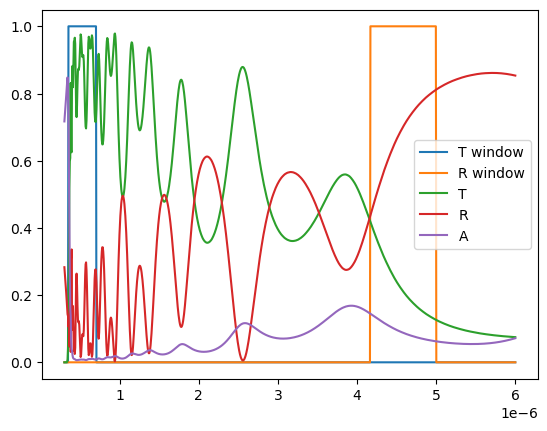

In [30]:
plt.plot(test.wavelength_array, test.transmissive_envelope, label='T window')
plt.plot(test.wavelength_array, test.reflective_envelope, label='R window')
plt.plot(test.wavelength_array, test.transmissivity_array, label='T')
plt.plot(test.wavelength_array, test.reflectivity_array, label='R')
plt.plot(test.wavelength_array, test.emissivity_array, label='A')
plt.legend()